
================  DAILY TRADING LOG  ================

2025-01-01  |  FLAT  |  NAV stays 10,000.00
2025-01-02 | FX SPOT | SHORT | 10,000.00$ | ret -1.09% -> pnl +109.45
2025-01-03 | APPLE | LONG  | 1,237.12$ | ret -0.20% -> pnl -2.49
2025-01-03 | BOEING | LONG  | 1,428.09$ | ret -1.15% -> pnl -16.37
2025-01-03 | CITI  | LONG  | 1,981.43$ | ret +1.52% -> pnl +30.03
2025-01-03 | BRENT | LONG  | 1,739.16$ | ret +0.76% -> pnl +13.28
2025-01-03 | MCDONALDS | LONG  | 1,895.51$ | ret +0.78% -> pnl +14.71
2025-01-03 | S&P 500 | LONG  | 1,828.14$ | ret +1.26% -> pnl +23.03
2025-01-06 | APPLE | LONG  | 1,382.39$ | ret +0.67% -> pnl +9.32
2025-01-06 | BOEING | LONG  | 1,688.62$ | ret +0.52% -> pnl +8.75
2025-01-06 | BRENT | LONG  | 2,071.62$ | ret -0.27% -> pnl -5.69
2025-01-06 | COCACOLA | LONG  | 1,216.51$ | ret -1.52% -> pnl -18.52
2025-01-06 | GOLD  | SHORT | 338.74$ | ret -0.27% -> pnl +0.93
2025-01-06 | S&P 500 | LONG  | 2,387.68$ | ret +0.55% -> pnl +13.22
2025-01-06 | US BONDS | SHORT | 

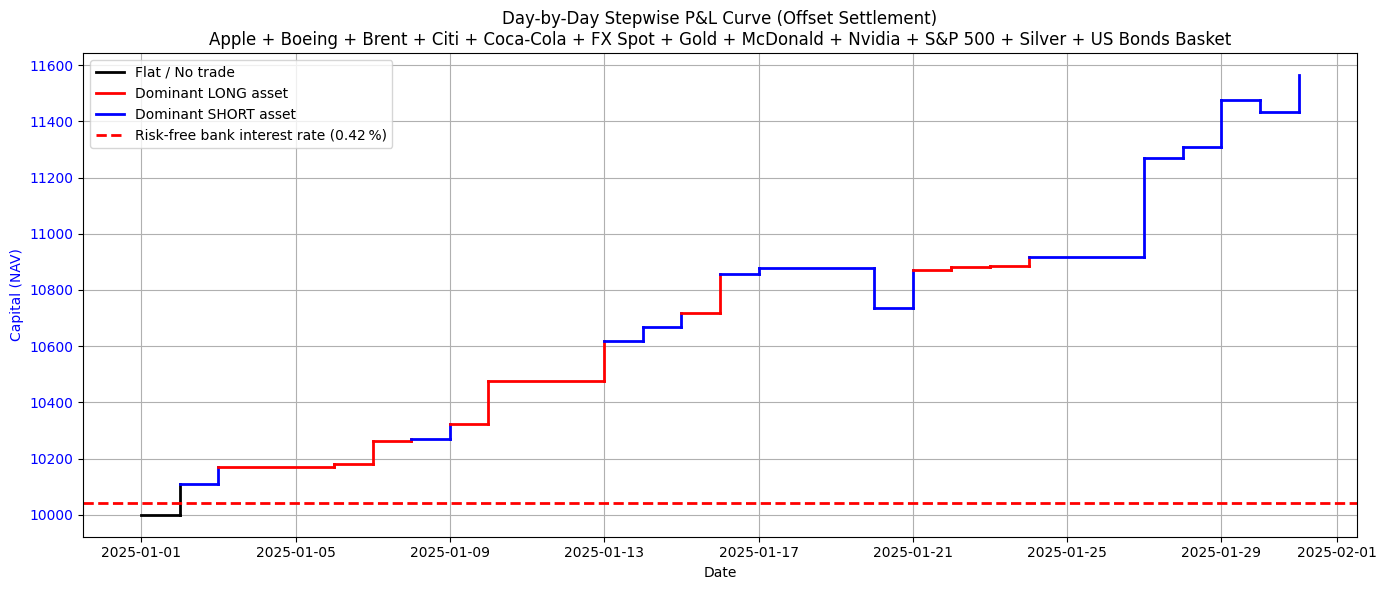

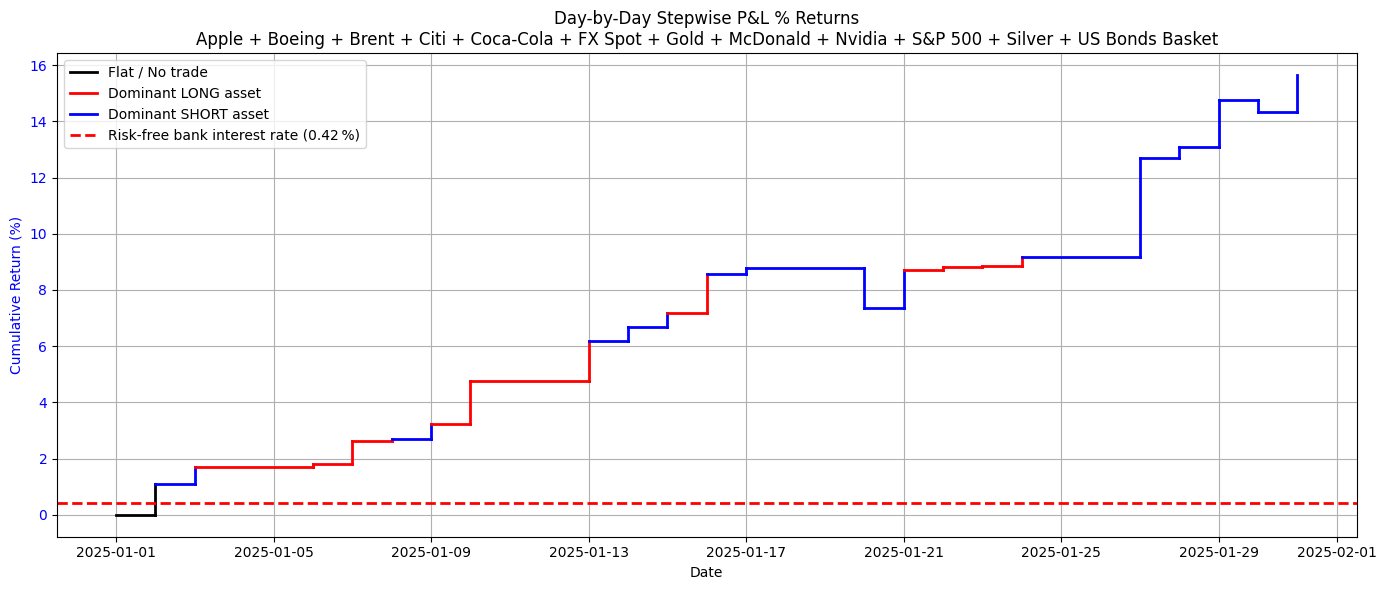

In [2]:
###############################################################################
# basket_trade_three_assets.py  –  Jan‑2025 basket trading (Citi + Brent + Coca‑Cola)
# (UPDATED: risk‑free rate reference lines added to both stepwise plots)
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# --------------------------------------------------------------------------- #
# 0) CONFIGURATION                                                            #
# --------------------------------------------------------------------------- #
INIT_NAV          = 10_000          # initial portfolio value
MAX_WEIGHT        = 0.75            # per‑asset weight cap
RISK_FREE_PCT_MO  = 0.42            # quoted as “0.42 % per month”
RISK_FREE_NAV_LVL = INIT_NAV * (1 + RISK_FREE_PCT_MO/100)  # 10 000 → 10 042

ASSETS = {
    "Apple":      dict(sig="signals_apple.csv",      conf="confidence_apple.csv",      ret="returns_apple.csv"),
    "Boeing":     dict(sig="signals_boeing.csv",     conf="confidence_boeing.csv",     ret="returns_boeing.csv"),
    "Citi":       dict(sig="signals_citi.csv",       conf="confidence_citi.csv",       ret="returns_citi.csv"),
    "Brent":      dict(sig="signals_brentoil.csv",   conf="confidence_brentoil.csv",   ret="returns_brentoil.csv"),
    "Cocacola":   dict(sig="signals_cocacola.csv",   conf="confidence_cocacola.csv",   ret="returns_cocacola.csv"),
    "FX Spot":    dict(sig="signals_fx_spot.csv",    conf="confidence_fx_spot.csv",    ret="returns_fx_spot.csv"),
    "Gold":       dict(sig="signals_gold.csv",       conf="confidence_gold.csv",       ret="returns_gold.csv"),
    "Mcdonalds":  dict(sig="signals_mcdonald.csv",   conf="confidence_mcdonald.csv",   ret="returns_mcdonald.csv"),
    "Nvidia":     dict(sig="signals_nvidia.csv",     conf="confidence_nvidia.csv",     ret="returns_nvidia.csv"),
    "S&P 500":    dict(sig="signals_s&p_500.csv",    conf="confidence_s&p_500.csv",    ret="returns_s&p_500.csv"),
    "Silver":     dict(sig="signals_silver.csv",     conf="confidence_silver.csv",     ret="returns_silver.csv"),
    "US Bonds":   dict(sig="signals_us_bonds.csv",   conf="confidence_us_bonds.csv",   ret="returns_us_bonds.csv"),
}

OUT_BASKET_NAV = "basket_nav_jan25_12assets.csv"
DATE_SLICE      = slice("2025-01-01", "2025-01-31")    # convenience
# --------------------------------------------------------------------------- #

def _load_col(fname: str, colname: str) -> pd.Series:
    """Load one column from CSV indexed by *date*."""
    s = (pd.read_csv(fname, parse_dates=["date"])
           .set_index("date")[colname])
    if not s.index.is_monotonic_increasing:
        s = s.sort_index()
    return s

# -------- 1) load & merge the feeds ---------------------------------------- #
frames = []
for asset, f in ASSETS.items():
    sig  = _load_col(f["sig"],  "signal").rename(f"{asset}_sig")
    conf = _load_col(f["conf"], "conf"  ).rename(f"{asset}_conf")
    ret  = _load_col(f["ret"],  "ret"   ).rename(f"{asset}_ret")
    frames.append(pd.concat([sig, conf, ret], axis=1))

basket_df = pd.concat(frames, axis=1).loc[DATE_SLICE].sort_index()

# -------- 1b) sanitise missing data ---------------------------------------- #
for a in ASSETS:
    basket_df[f"{a}_sig"]  = basket_df[f"{a}_sig"].fillna(0)
    basket_df[f"{a}_conf"] = basket_df[f"{a}_conf"].fillna(0)
    basket_df[f"{a}_ret"]  = basket_df[f"{a}_ret"].fillna(0)

# -------- 2) back‑test loop ------------------------------------------------ #
nav_hist, trade_log = [], []
nav = INIT_NAV

for dt, row in basket_df.iterrows():

    active = [a for a in ASSETS if row[f"{a}_sig"] != 0]
    if not active:                                  # all flat
        nav_hist.append({"date": dt, "nav": nav, "sig": 0})
        trade_log.append(f"{dt.date()}  |  FLAT  |  NAV stays {nav:,.2f}")
        continue

    # 2a) derive weights from confidences ------------------------------------ #
    confs    = {a: row[f"{a}_conf"] for a in active}
    tot_conf = sum(confs.values())
    if tot_conf <= 0 or np.isnan(tot_conf):
        weights = {a: 1/len(active) for a in active}
    else:
        weights = {a: min(confs[a]/tot_conf, MAX_WEIGHT) for a in active}
        scale   = 1 / sum(weights.values())
        weights = {a: w*scale for a, w in weights.items()}

    # 2b) apply PnL and pick *dominant* position ----------------------------- #
    daily_pnl   = 0.0
    dom_pnl_abs = -np.inf   # largest |pnl|
    dom_sig     = 0         # +1 (long) / ‑1 (short) / 0 (flat)
    for a in active:
        capital_i = nav * weights[a]
        pnl_i     = capital_i * row[f"{a}_sig"] * row[f"{a}_ret"]
        daily_pnl += pnl_i

        # track the trade with greatest absolute impact
        if abs(pnl_i) > dom_pnl_abs:
            dom_pnl_abs = abs(pnl_i)
            dom_sig     = int(np.sign(row[f"{a}_sig"]))

        trade_log.append(
            f"{dt.date()} | {a.upper():5s} | "
            f"{'LONG' if row[f'{a}_sig']>0 else 'SHORT':5s} | "
            f"{capital_i:,.2f}$ | ret {row[f'{a}_ret']*100:+.2f}% -> pnl {pnl_i:+.2f}"
        )

    nav += daily_pnl
    nav_hist.append({"date": dt, "nav": nav, "sig": dom_sig})

# -------- 3) results to CSV + console summary ------------------------------ #
nav_df = pd.DataFrame(nav_hist).set_index("date")
nav_df["cum_ret_%"] = 100 * (nav_df["nav"]/INIT_NAV - 1)
nav_df.to_csv(OUT_BASKET_NAV, float_format="%.6f")

print("\n================  DAILY TRADING LOG  ================\n")
for line in trade_log:
    print(line)

final_ret = nav_df["cum_ret_%"].iloc[-1]
print("\n================  SUMMARY  ==========================")
print(f"Final NAV: {nav_df['nav'].iloc[-1]:,.2f} ({final_ret:+.2f} %)  —  written → {OUT_BASKET_NAV}")

# --------------------------------------------------------------------------- #
# 4) PLOTTING  –  step‑wise curves coloured by dominant position              #
# --------------------------------------------------------------------------- #
def _step_plot(ax, x, y, sig):
    colour = {1: "red", -1: "blue", 0: "black"}
    for i in range(1, len(x)):
        c = colour.get(sig[i-1], "black")
        ax.plot([x[i-1], x[i]], [y[i-1], y[i-1]], color=c, lw=2)  # horizontal
        ax.plot([x[i], x[i]],   [y[i-1], y[i]],   color=c, lw=2)  # vertical

def _plot_core(series, ylabel, title, risk_line_y, risk_line_label):
    fig, ax = plt.subplots(figsize=(14,6))
    dates = series.index.to_pydatetime()
    _step_plot(ax, dates, series.values, nav_df["sig"].values)

    # ↓↓↓  **NEW**  risk‑free reference line
    ax.axhline(y=risk_line_y, color="red", linestyle="--",
               linewidth=2, label=risk_line_label)

    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel, color="blue")
    ax.tick_params(axis="y", labelcolor="blue")
    ax.grid(True)
    legend = [
        Line2D([0],[0], color='black', lw=2, label='Flat / No trade'),
        Line2D([0],[0], color='red',   lw=2, label='Dominant LONG asset'),
        Line2D([0],[0], color='blue',  lw=2, label='Dominant SHORT asset'),
        Line2D([0],[0], color='red',   lw=2, linestyle='--', label=risk_line_label)
    ]
    ax.legend(handles=legend, loc="upper left")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# ---- PLOT 1 – NAV curve with risk‑free level ------------------------------ #
_plot_core(
    nav_df["nav"],
    ylabel="Capital (NAV)",
    title=("Day-by-Day Stepwise P&L Curve (Offset Settlement)\n"
           "Apple + Boeing + Brent + Citi + Coca‑Cola + FX Spot + Gold "
           "+ McDonald + Nvidia + S&P 500 + Silver + US Bonds Basket"),
    risk_line_y=RISK_FREE_NAV_LVL,
    risk_line_label=f"Risk‑free bank interest rate ({RISK_FREE_PCT_MO:.2f} %)"
)

# ---- PLOT 2 – Cumulative % returns with risk‑free % ----------------------- #
_plot_core(
    nav_df["cum_ret_%"],
    ylabel="Cumulative Return (%)",
    title=("Day-by-Day Stepwise P&L % Returns\n"
           "Apple + Boeing + Brent + Citi + Coca‑Cola + FX Spot + Gold "
           "+ McDonald + Nvidia + S&P 500 + Silver + US Bonds Basket"),
    risk_line_y=RISK_FREE_PCT_MO,           # 0.42 %
    risk_line_label=f"Risk‑free bank interest rate ({RISK_FREE_PCT_MO:.2f} %)"
)


Tidy trade‑log written → daily_trade_log.csv
Figure saved → fig_daily_pnl.png
Figure saved → fig_heatmap_pnl.png


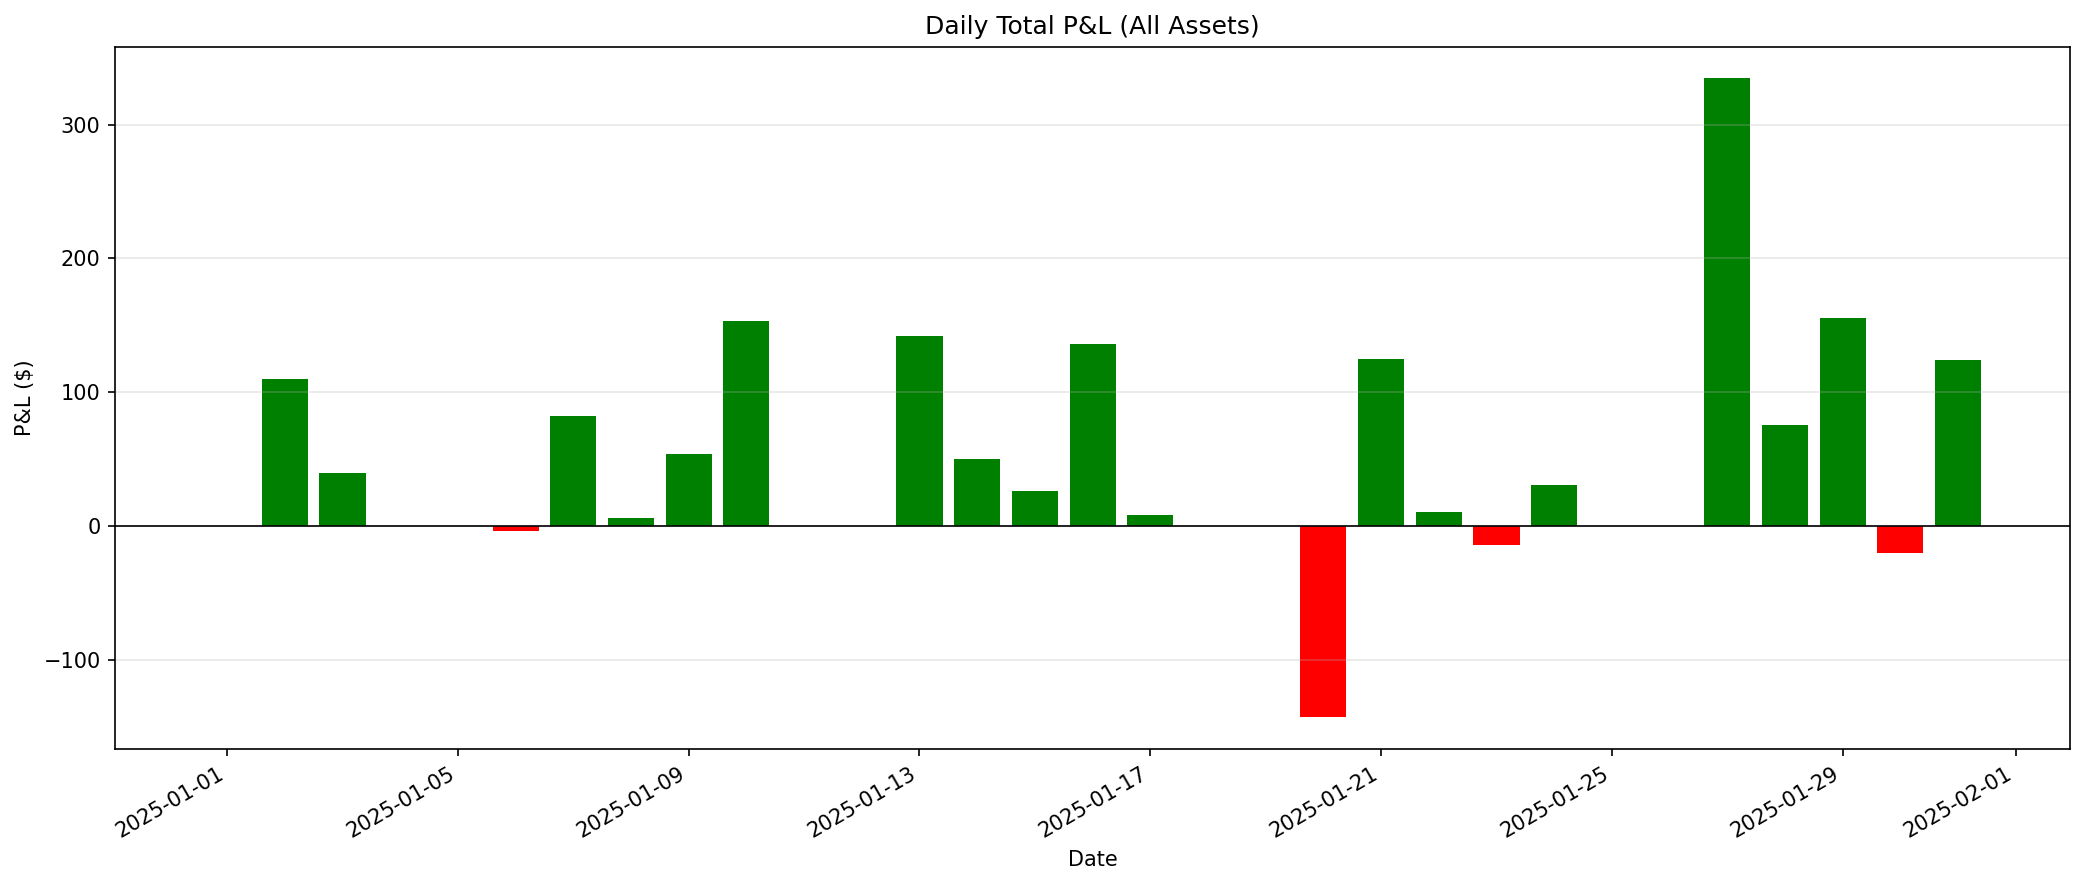

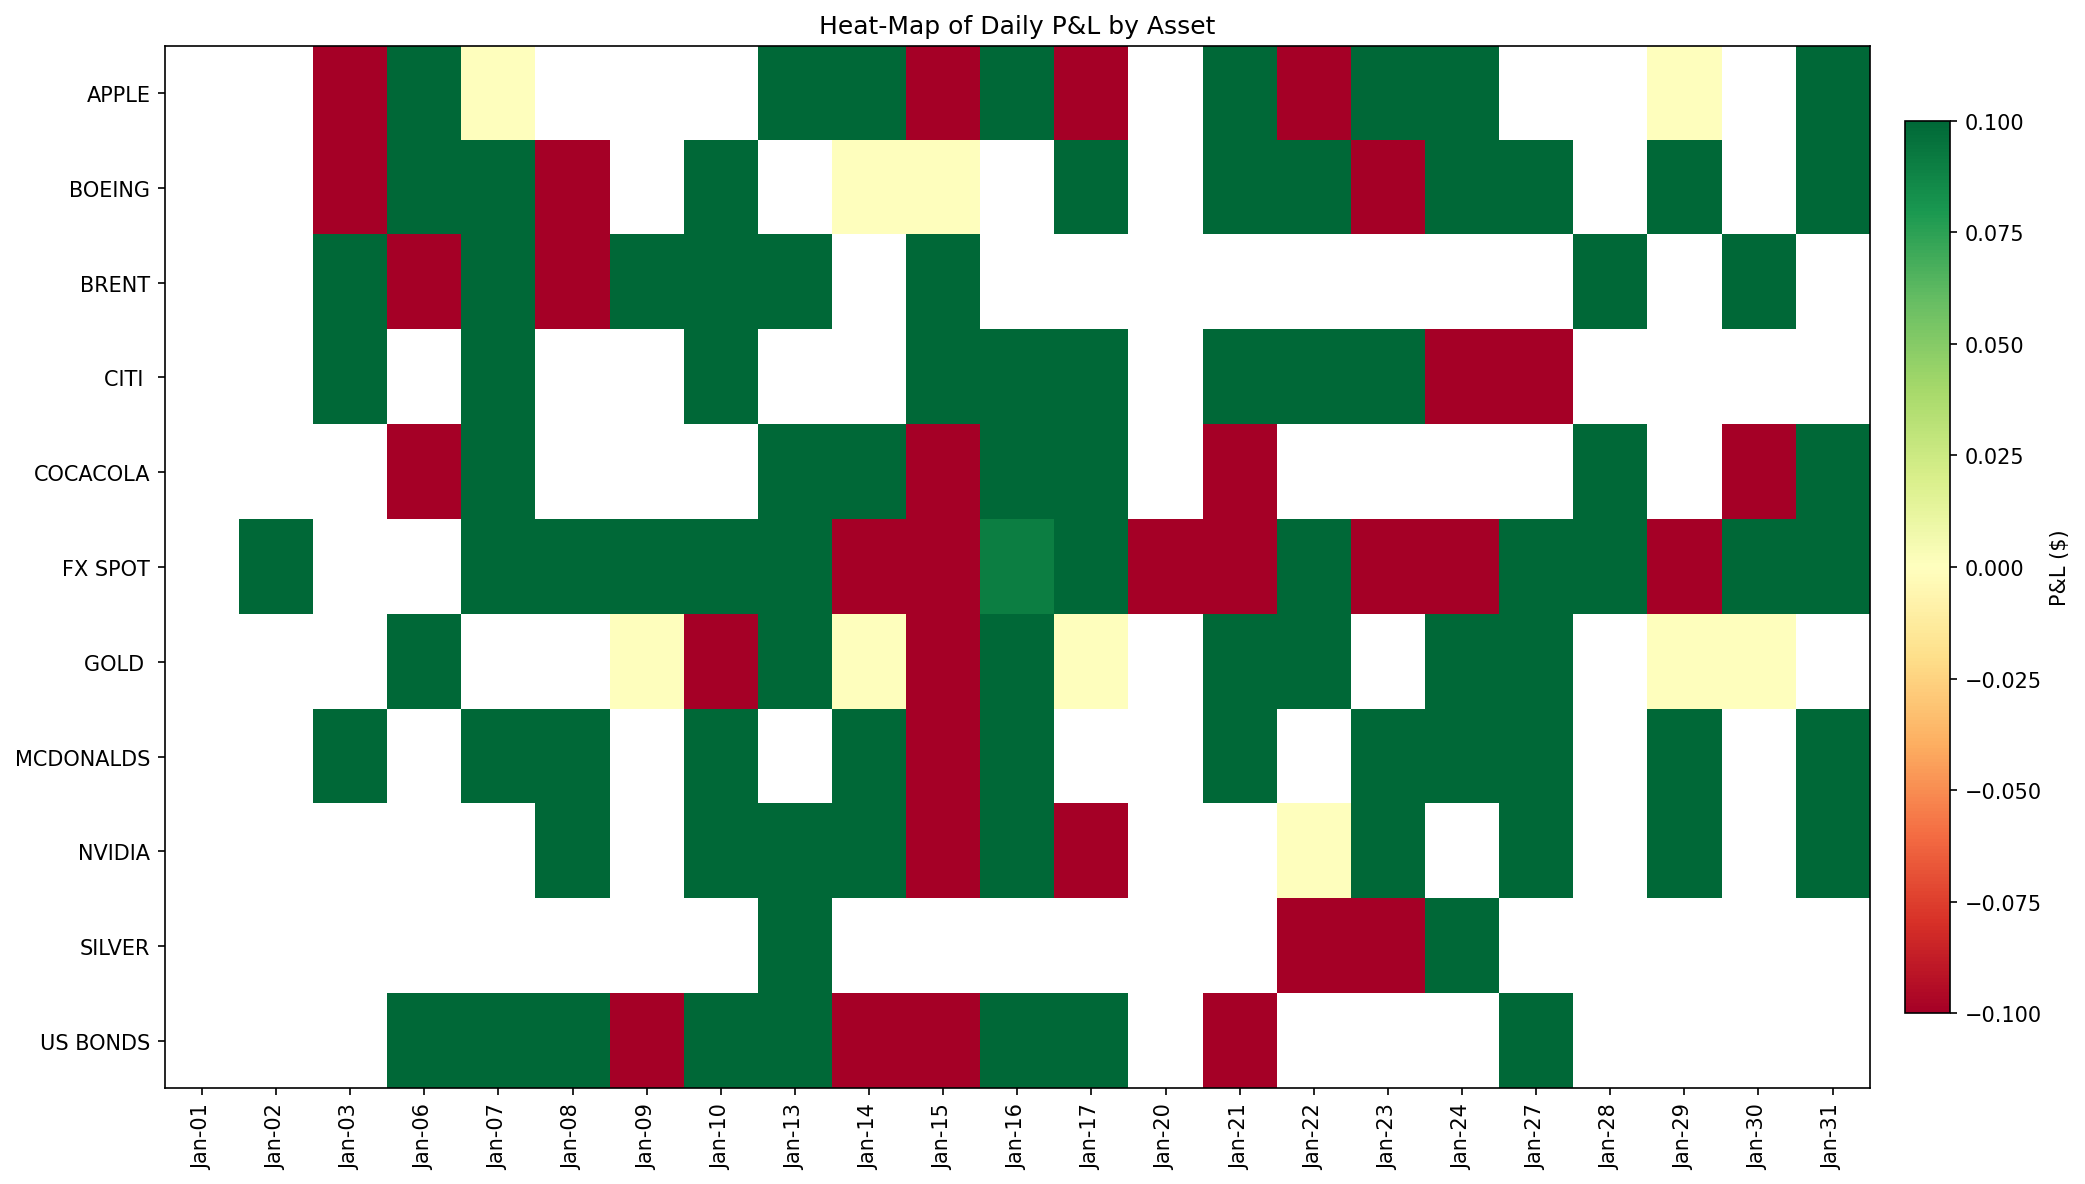

In [3]:
# ------------------------------------------------------ #
# 5)  VISUALISING THE TRADE LOG                          #
# ------------------------------------------------------ #
import re

# --- 5a) convert the plain‑text trade_log to a DataFrame
pattern = re.compile(
    r"(?P<date>\d{4}-\d{2}-\d{2})\s+\|\s+"
    r"(?P<asset>[A-Z &]+)\s+\|\s+"
    r"(?P<dir>LONG|SHORT|FLAT)\s+\|\s+"
    r"(?P<capital>[\d,\.]+)\$\s+\|\s+ret\s+"
    r"(?P<ret>[-+]?[\d\.]+)%\s+->\s+pnl\s+"
    r"(?P<pnl>[-+]?[\d\.]+)"
)

records = []
for line in trade_log:
    m = pattern.search(line)
    if m:                       # ignore the first “FLAT” row
        rec = m.groupdict()
        rec["date"]    = pd.to_datetime(rec["date"])
        rec["capital"] = float(rec["capital"].replace(",", ""))
        rec["ret"]     = float(rec["ret"])
        rec["pnl"]     = float(rec["pnl"])
        records.append(rec)

log_df = pd.DataFrame(records)
log_df.to_csv("daily_trade_log.csv", index=False)
print("Tidy trade‑log written → daily_trade_log.csv")

# ------------------------------------------------------ #
# 5b) FIGURE 1 — total daily P&L bar‑chart
# ------------------------------------------------------ #
daily_pnl = (log_df.groupby("date")["pnl"].sum()
                       .reindex(nav_df.index, fill_value=0))  # align to all days

fig1, ax1 = plt.subplots(figsize=(14,6), dpi=150)
colors = daily_pnl.apply(lambda x: "green" if x >= 0 else "red")
ax1.bar(daily_pnl.index, daily_pnl.values, color=colors)
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_title("Daily Total P&L (All Assets)")
ax1.set_ylabel("P&L ($)")
ax1.set_xlabel("Date")
ax1.grid(True, axis="y", alpha=0.3)
fig1.autofmt_xdate()
fig1.tight_layout()
fig1.savefig("fig_daily_pnl.png")
print("Figure saved → fig_daily_pnl.png")

# ------------------------------------------------------ #
# 5c) FIGURE 2 — heat‑map of P&L by asset & day
# ------------------------------------------------------ #
# pivot table: rows = date, cols = asset, values = pnl
pivot = (log_df.pivot_table(index="date",
                            columns="asset",
                            values="pnl",
                            aggfunc="sum")
                 .reindex(nav_df.index))        # keep calendar continuity

fig2, ax2 = plt.subplots(figsize=(14,8), dpi=150)
im = ax2.imshow(pivot.T, aspect="auto", cmap="RdYlGn",
                vmin=-abs(pivot.values).max(),
                vmax= abs(pivot.values).max())

# axis formatting
ax2.set_yticks(range(len(pivot.columns)))
ax2.set_yticklabels(pivot.columns)
ax2.set_xticks(range(len(pivot.index)))
ax2.set_xticklabels(pivot.index.strftime("%b‑%d"), rotation=90)
ax2.set_title("Heat‑Map of Daily P&L by Asset")
cbar = fig2.colorbar(im, ax=ax2, fraction=0.025, pad=0.02)
cbar.set_label("P&L ($)")
fig2.tight_layout()
fig2.savefig("fig_heatmap_pnl.png")
print("Figure saved → fig_heatmap_pnl.png")


/tmp/ipykernel_935224/232215653.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(trade_counts.index, rotation=45, ha="right")


Figure saved → fig_trades_per_asset.png
Figure saved → fig_trade_direction_heatmap.png


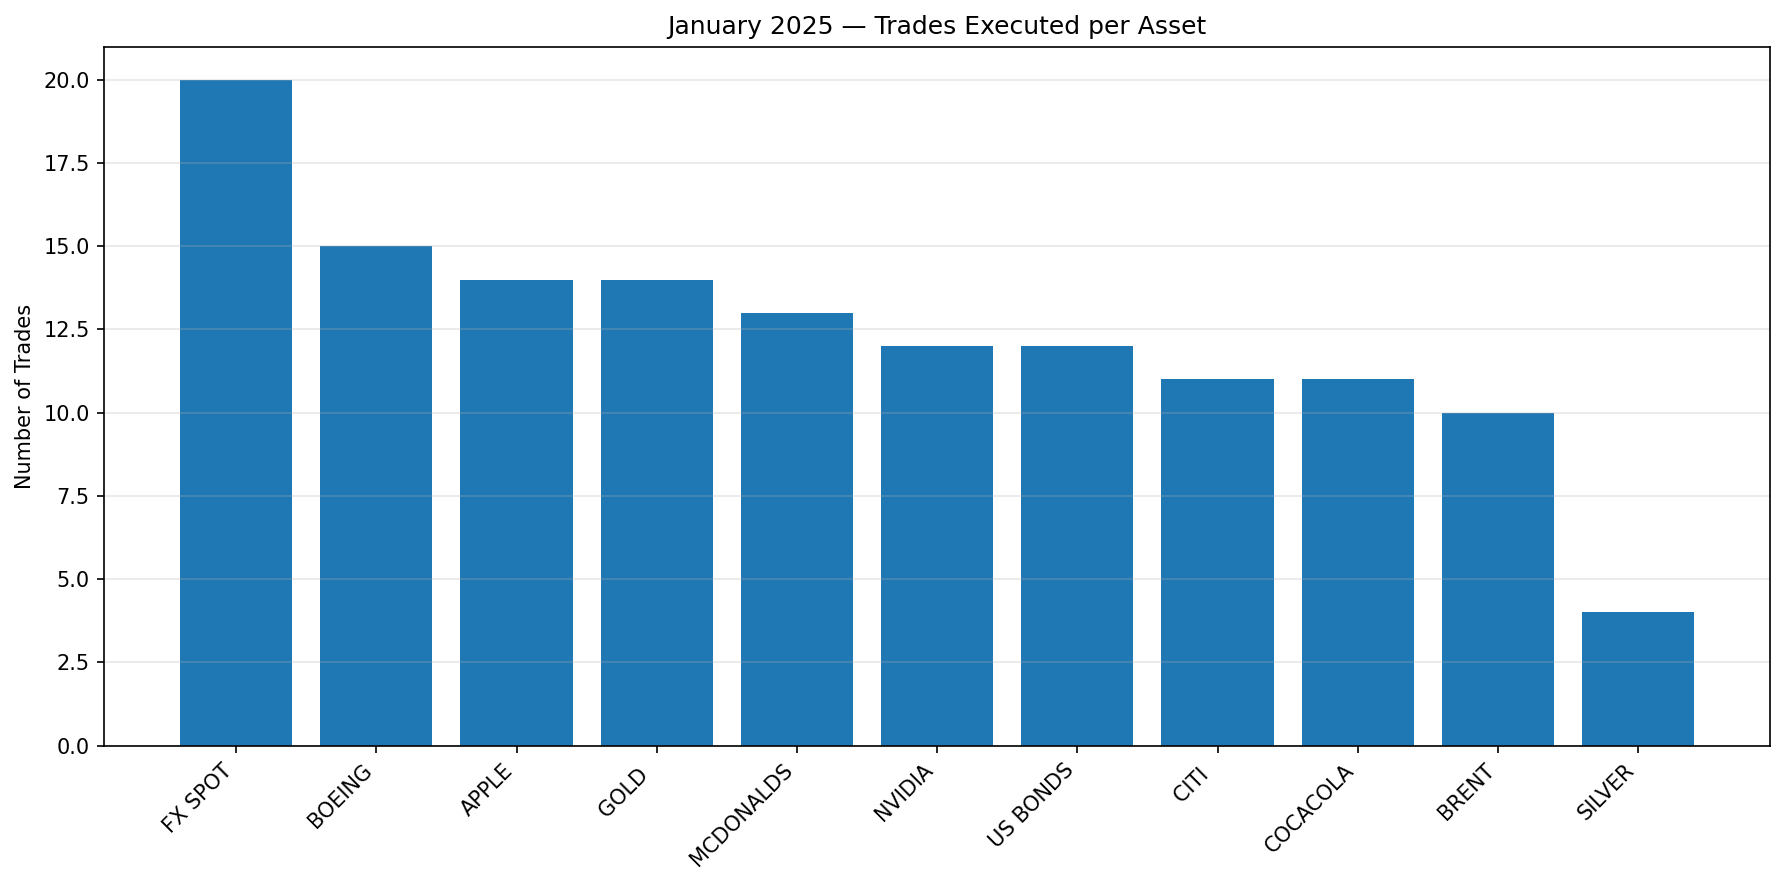

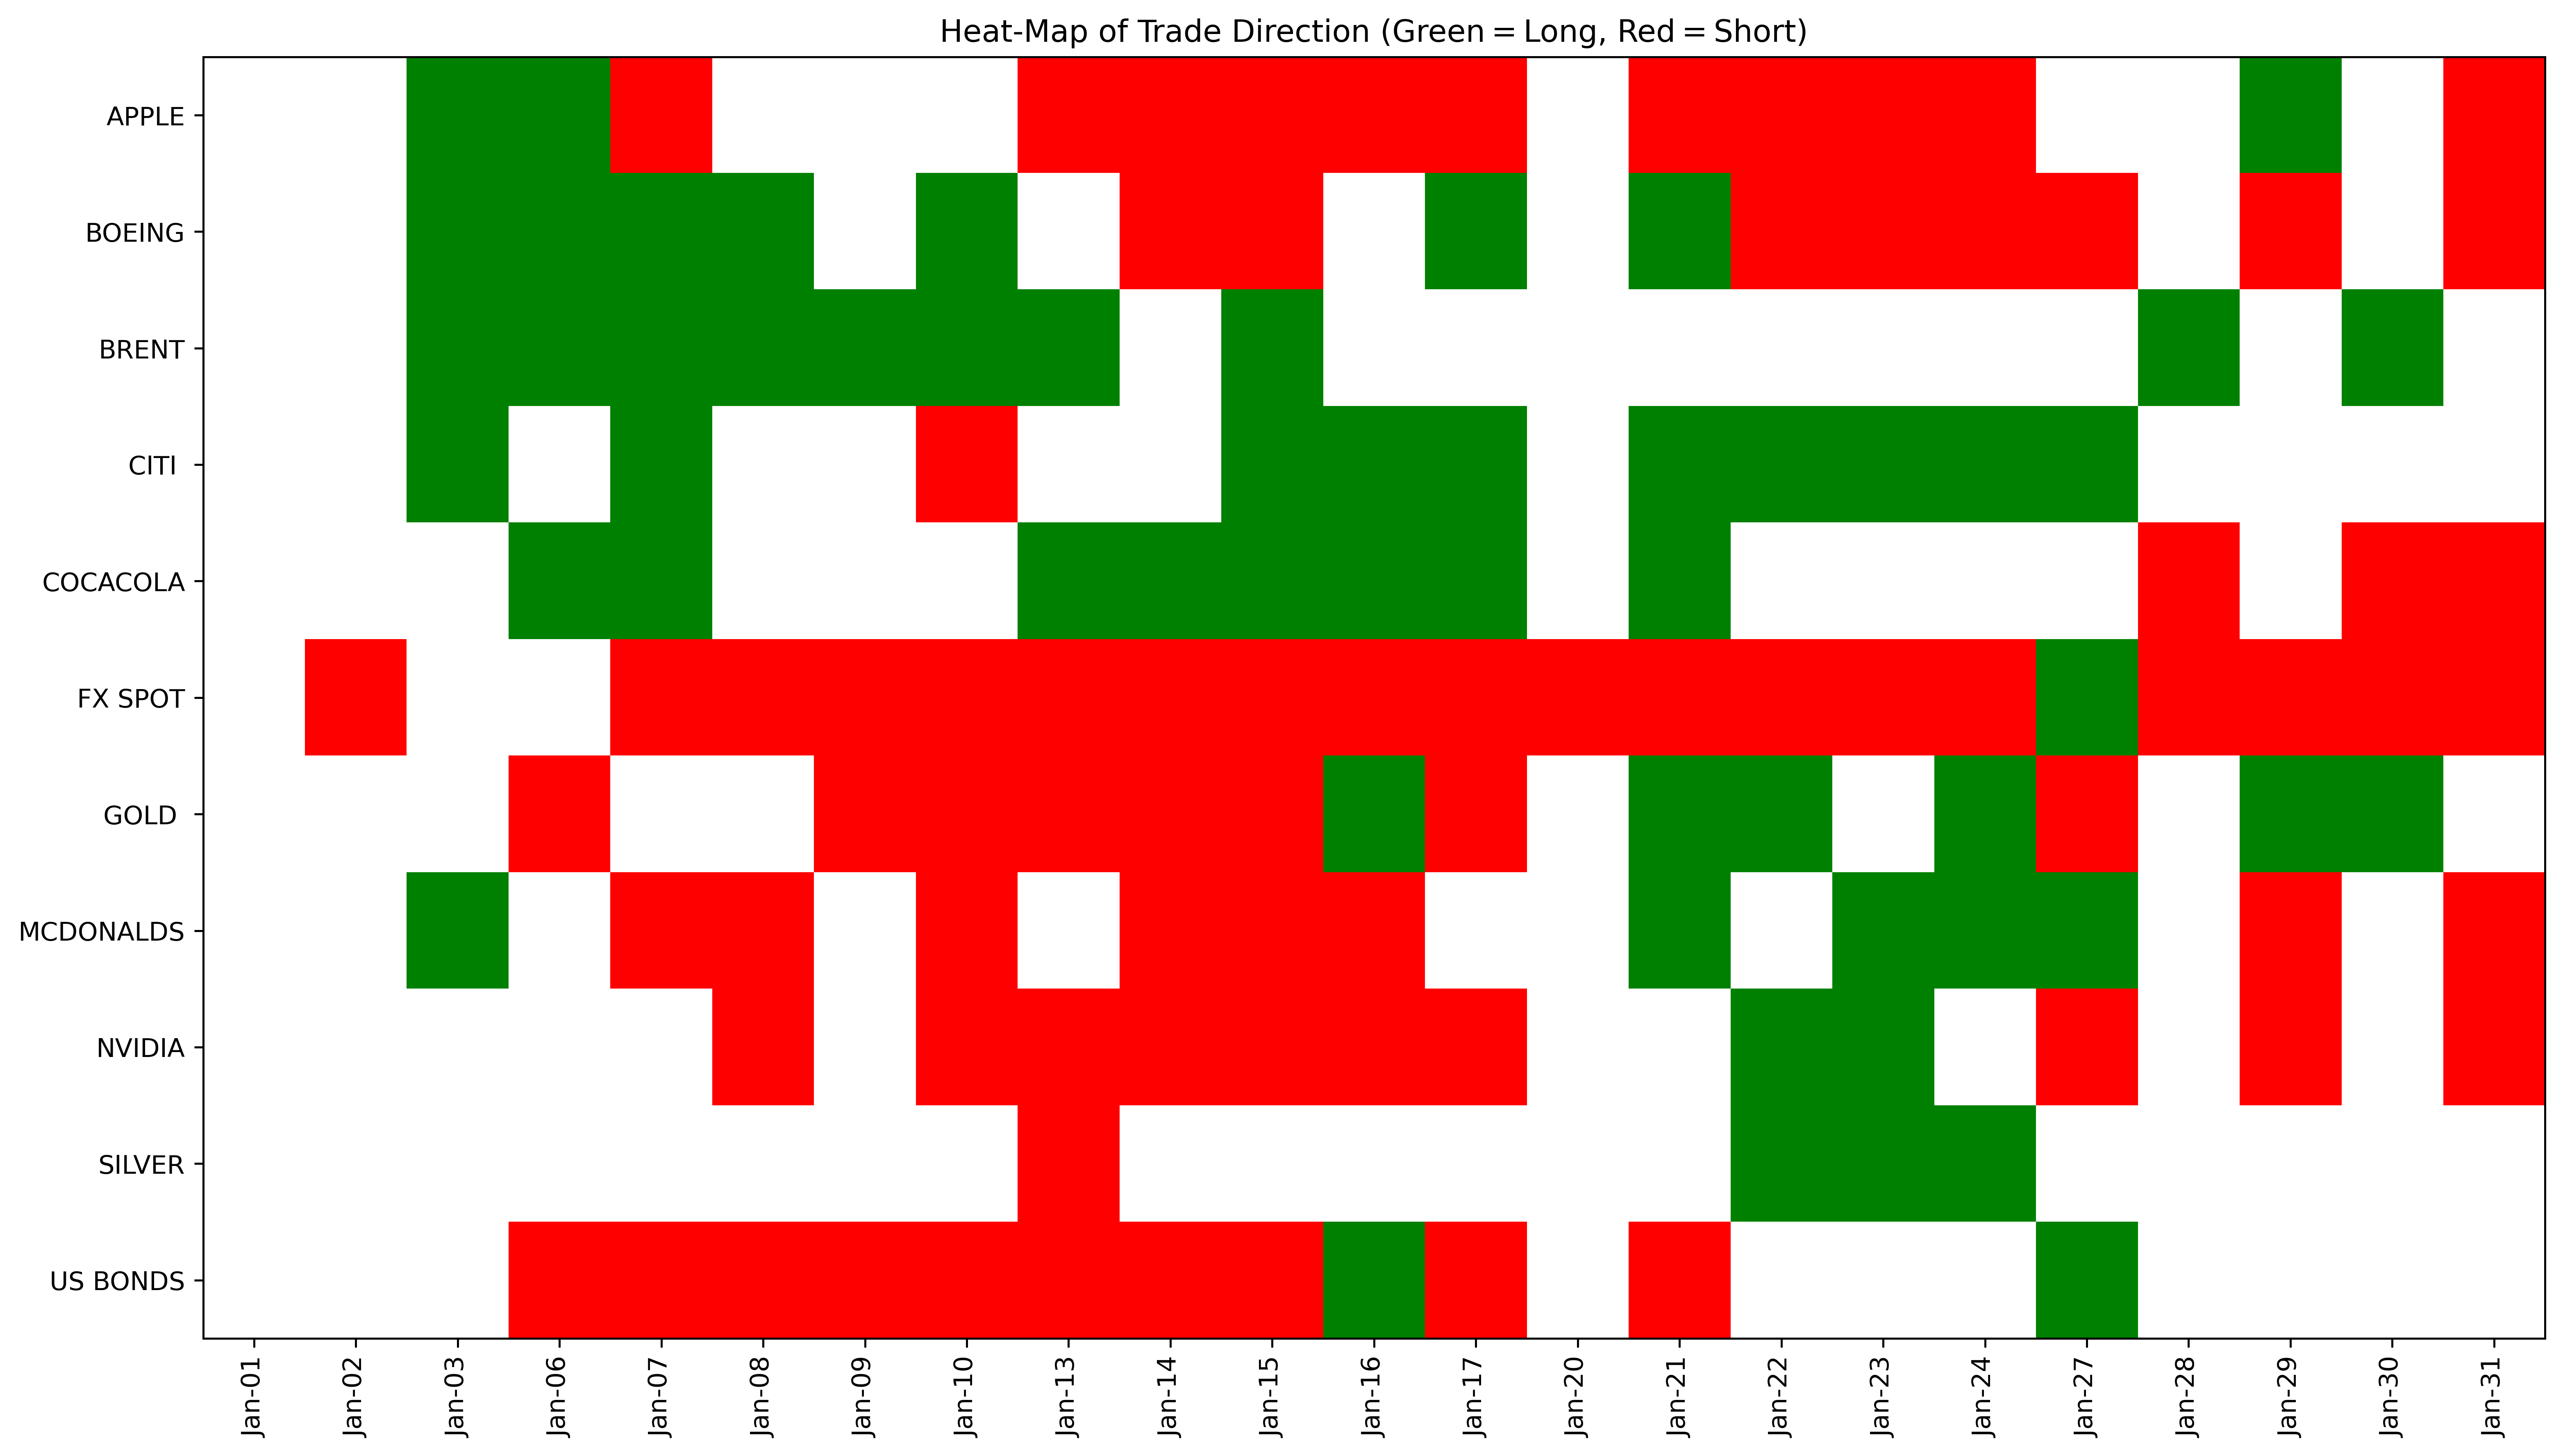

In [4]:
# ------------------------------------------------------ #
# 5d)  FIGURE 3 — number of trades per asset
# ------------------------------------------------------ #
# (count both LONG and SHORT; ignore FLAT placeholder rows)
trade_counts = (log_df.query("dir != 'FLAT'")
                         .groupby("asset")["dir"]
                         .count()
                         .sort_values(ascending=False))

fig3, ax3 = plt.subplots(figsize=(12,6), dpi=150)
ax3.bar(trade_counts.index, trade_counts.values)
ax3.set_ylabel("Number of Trades")
ax3.set_title("January 2025 — Trades Executed per Asset")
ax3.set_xticklabels(trade_counts.index, rotation=45, ha="right")
ax3.grid(axis="y", alpha=0.3)
fig3.tight_layout()
fig3.savefig("fig_trades_per_asset.png")
print("Figure saved → fig_trades_per_asset.png")

# ------------------------------------------------------ #
# 5e)  FIGURE 4 — heat‑map of trade DIRECTION (not P&L)
# ------------------------------------------------------ #
# Map LONG→ +1, SHORT→ ‑1, FLAT/no trade → 0
dir_map = {"LONG": 1, "SHORT": -1}
dir_df  = (log_df.assign(dir_num=lambda d: d["dir"].map(dir_map).fillna(0))
                   .pivot_table(index="date",
                                columns="asset",
                                values="dir_num",
                                aggfunc="sum")
                   .reindex(nav_df.index)     # preserve calendar continuity
                   .fillna(0)
                   .astype(int))

from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(["red", "white", "green"])      # ‑1  0  +1
norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

fig4, ax4 = plt.subplots(figsize=(14,8), dpi=450)
im = ax4.imshow(dir_df.T, aspect="auto", cmap=cmap, norm=norm)

# axis labelling
ax4.set_yticks(range(len(dir_df.columns)))
ax4.set_yticklabels(dir_df.columns)
ax4.set_xticks(range(len(dir_df.index)))
ax4.set_xticklabels(dir_df.index.strftime("%b‑%d"), rotation=90)
ax4.set_title("Heat‑Map of Trade Direction (Green = Long, Red = Short)")
fig4.tight_layout()
fig4.savefig("fig_trade_direction_heatmap.png")
print("Figure saved → fig_trade_direction_heatmap.png")


Figure saved → fig_trade_direction_heatmap_bordered.png


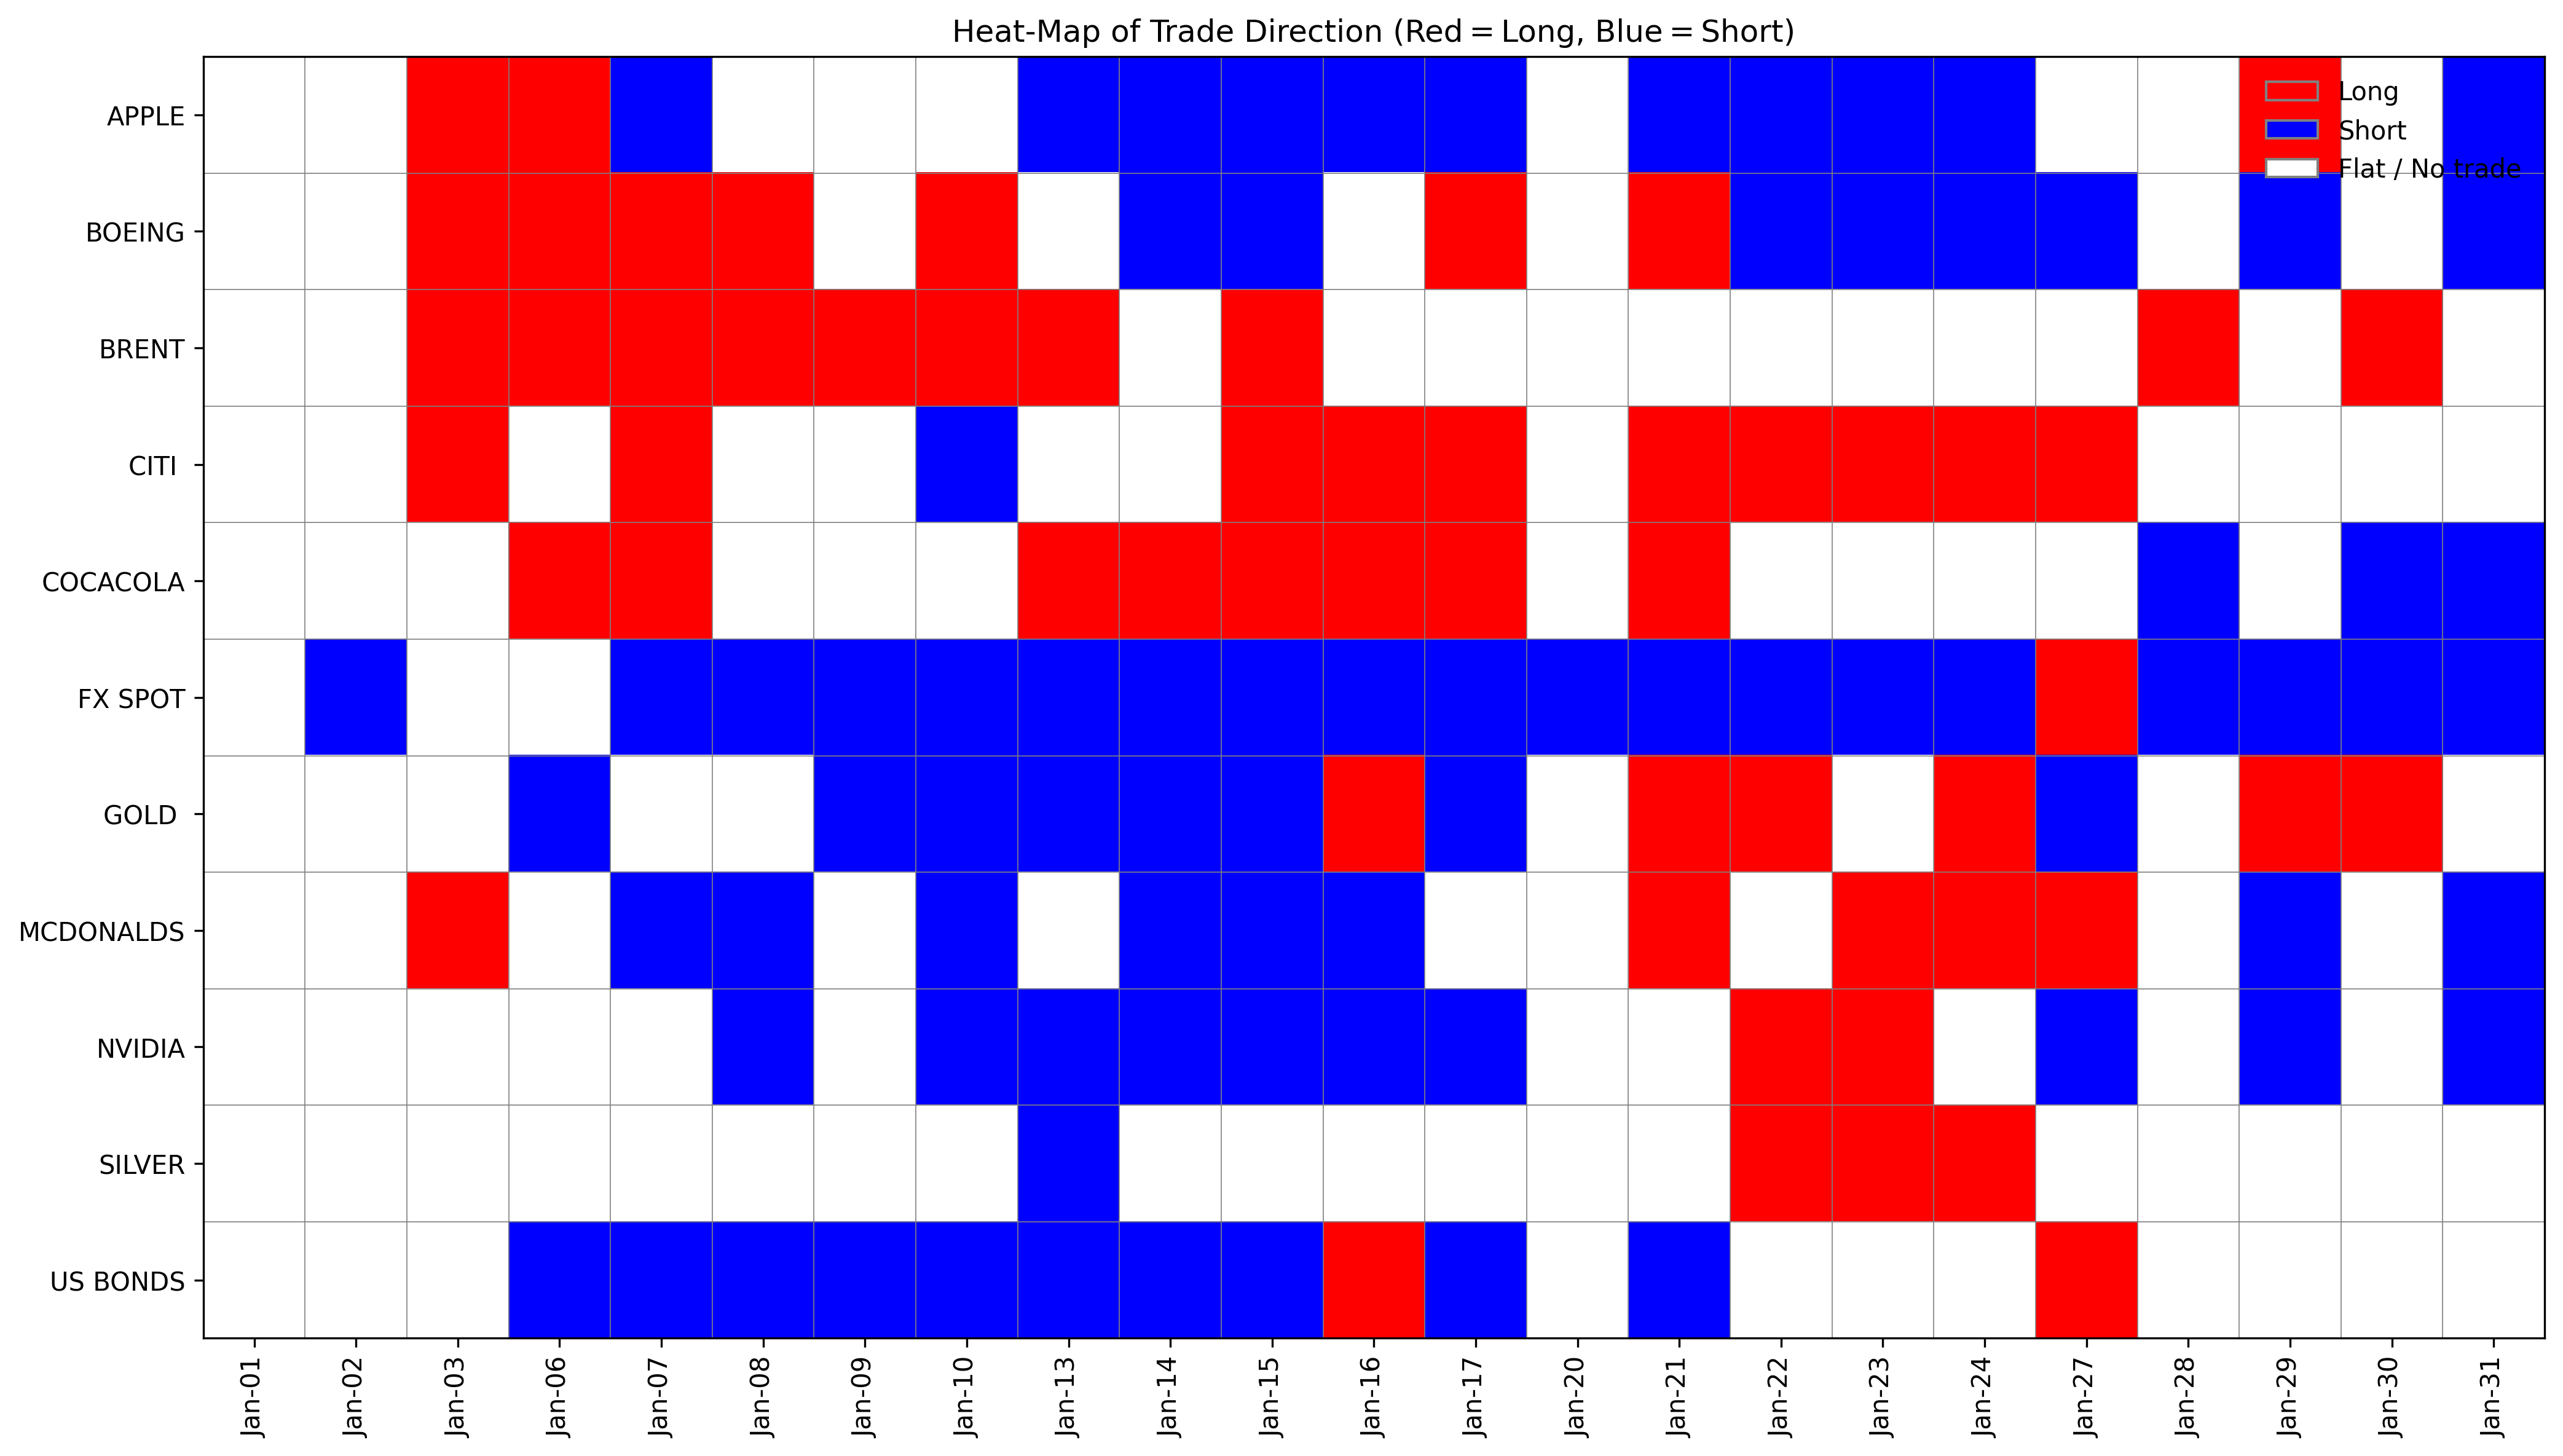

In [5]:
# ------------------------------------------------------ #
# 5e)  FIGURE 4  — trade‑direction heat‑map (bordered,
#                  LONG = red, SHORT = blue, FLAT = white)
# ------------------------------------------------------ #
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# 1️⃣  map LONG→+1, SHORT→‑1, FLAT/no trade→0
dir_map = {"LONG": 1, "SHORT": -1}
dir_df  = (log_df.assign(dir_num=lambda d: d["dir"].map(dir_map).fillna(0))
                   .pivot_table(index="date",
                                columns="asset",
                                values="dir_num",
                                aggfunc="sum")
                   .reindex(nav_df.index)     # keep calendar continuity
                   .fillna(0)
                   .astype(int))

# 2️⃣  colour map & normalisation
#     index: 0 = blue (short), 1 = white (flat), 2 = red (long)
cmap = ListedColormap(["blue", "white", "red"])
norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)

fig4, ax4 = plt.subplots(figsize=(14,8), dpi=300)
im = ax4.imshow(dir_df.T, aspect="auto", cmap=cmap, norm=norm)

# 3️⃣  grid lines to give each day/asset cell a border
ax4.set_xticks(np.arange(-0.5, len(dir_df.index), 1), minor=True)
ax4.set_yticks(np.arange(-0.5, len(dir_df.columns), 1), minor=True)
ax4.grid(which="minor", color="grey", linestyle="-", linewidth=0.4)
ax4.tick_params(which="minor", bottom=False, left=False)

# 4️⃣  axis labelling
ax4.set_yticks(range(len(dir_df.columns)))
ax4.set_yticklabels(dir_df.columns)
ax4.set_xticks(range(len(dir_df.index)))
ax4.set_xticklabels(dir_df.index.strftime("%b‑%d"), rotation=90)
ax4.set_title("Heat‑Map of Trade Direction (Red = Long, Blue = Short)")

# 5️⃣  legend proxy (optional but handy)
from matplotlib.patches import Patch
legend_elems = [
    Patch(facecolor="red",  edgecolor="grey", label="Long"),
    Patch(facecolor="blue", edgecolor="grey", label="Short"),
    Patch(facecolor="white", edgecolor="grey", label="Flat / No trade"),
]
ax4.legend(handles=legend_elems, loc="upper right", frameon=False)

fig4.tight_layout()
fig4.savefig("fig_trade_direction_heatmap_bordered.png")
print("Figure saved → fig_trade_direction_heatmap_bordered.png")


Figure saved → fig_trade_dir_intensity.png


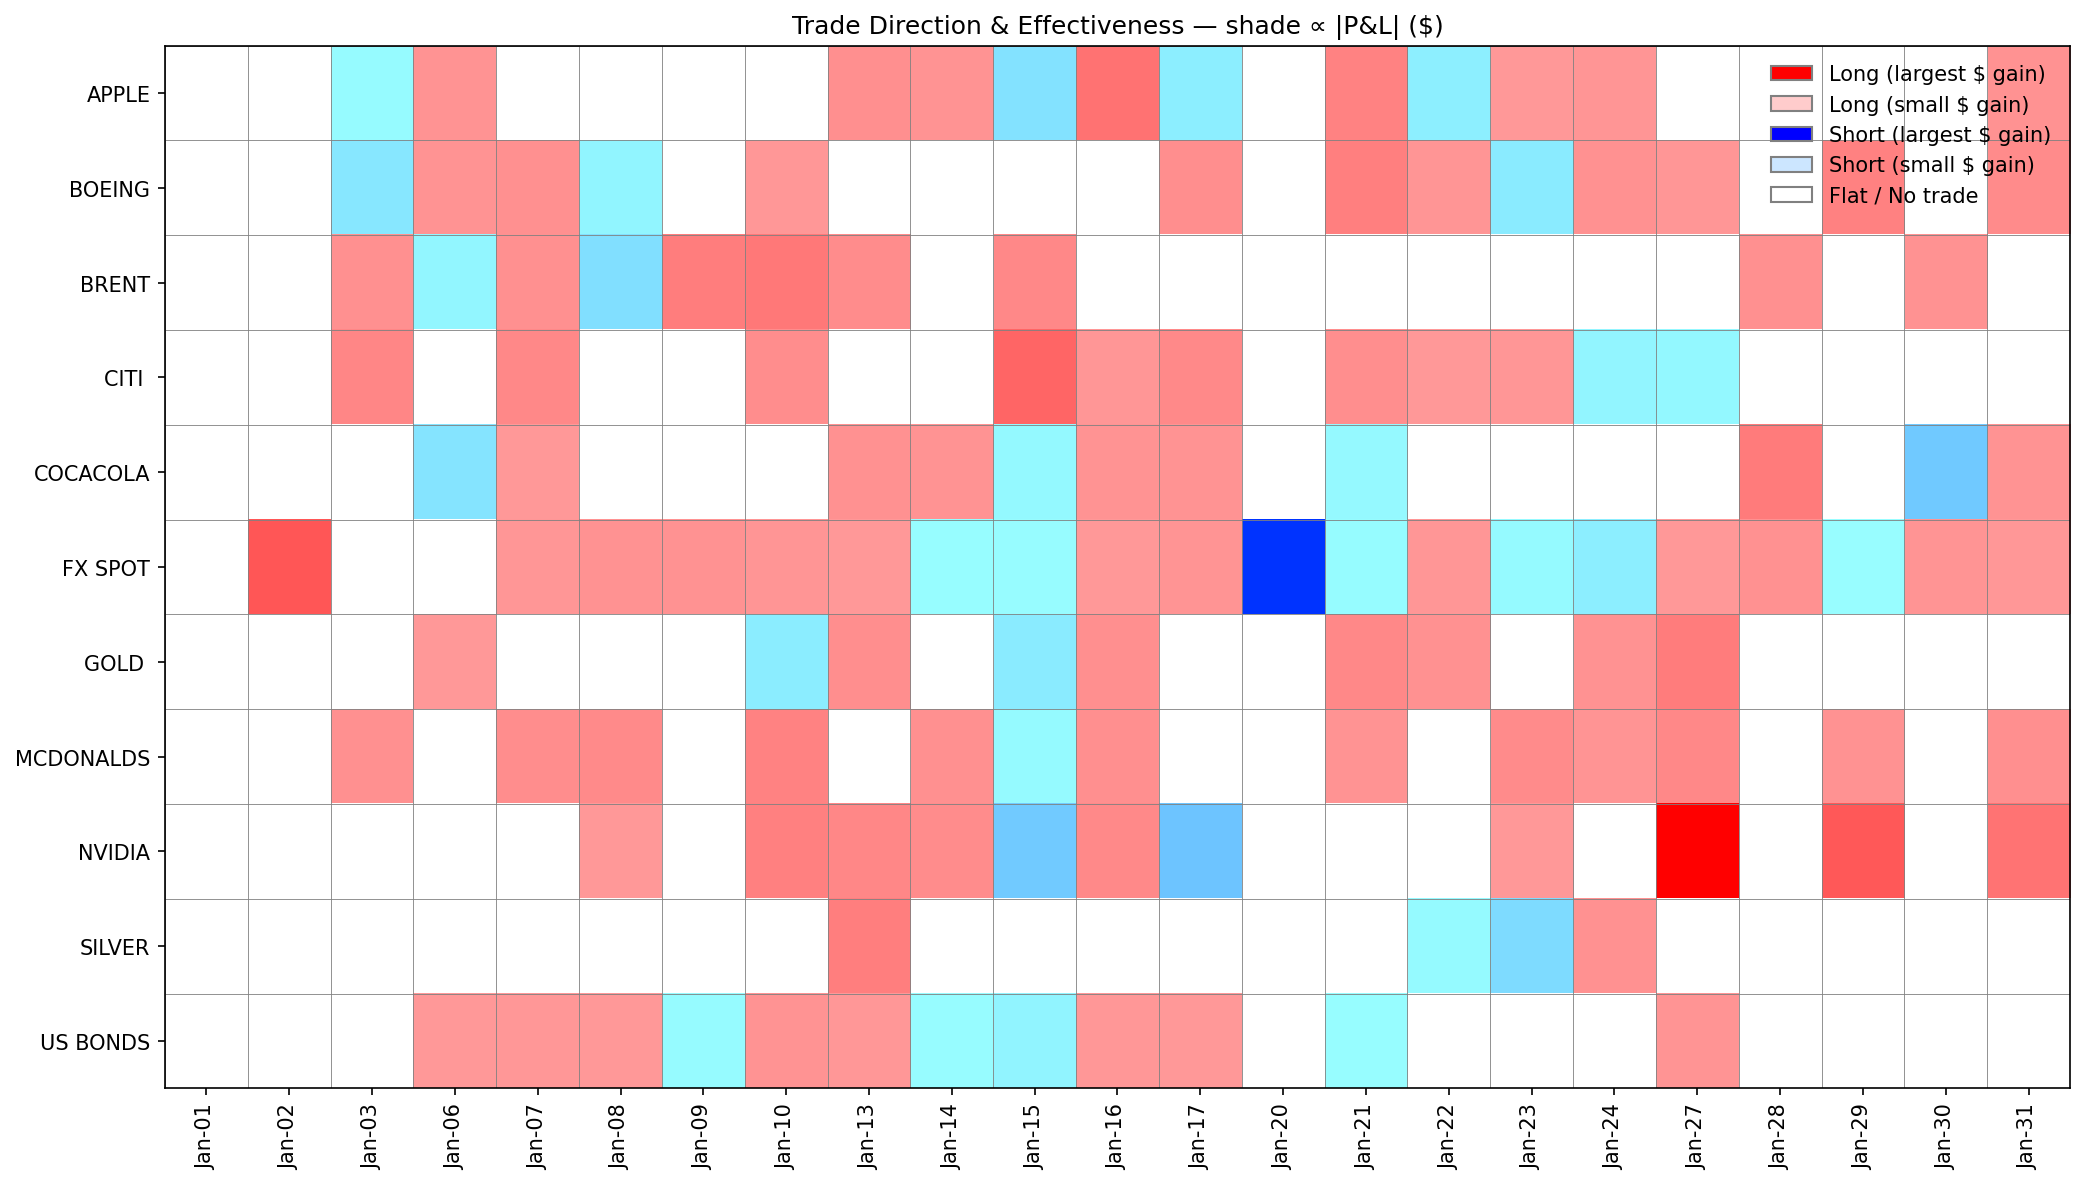

In [6]:
# ------------------------------------------------------ #
# 5f) HEAT‑MAP 2.0 — Direction *and* P&L intensity
#      • LONG  → shades of red   (deeper = bigger $ gain)
#      • SHORT → shades of blue  (deeper = bigger $ gain)
#      • FLAT  → white
# ------------------------------------------------------ #
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

# ── 1️⃣  day‑×‑asset grid of *net‑$‑P&L* ──────────────────────────────────
pnl_df = (log_df.pivot_table(index="date",
                             columns="asset",
                             values="pnl",
                             aggfunc="sum")
                  .reindex(nav_df.index)       # keep full calendar
                  .fillna(0.0))

# ── 2️⃣  normalisation constants for colour scaling ───────────────────────
abs_max_long  = pnl_df.where(pnl_df >  0).max().max() or 1e-12
abs_max_short = (-pnl_df.where(pnl_df < 0)).max().max() or 1e-12

def _cell_colour(pnl):
    """Return an RGBA tuple encoding direction & |P&L| size."""
    if np.isclose(pnl, 0):
        return (1, 1, 1, 1)                       # white  – flat / no trade
    if pnl > 0:                                   # profitable long
        frac = pnl / abs_max_long
        return (1, 0.6*(1-frac), 0.6*(1-frac), 1) # light‑pink → deep‑red
    else:                                         # profitable short
        frac = (-pnl) / abs_max_short
        return (0.6*(1-frac), 0.8*(1-frac)+0.2, 1, 1)  # light‑sky → deep‑blue

# ── 3️⃣  build RGBA image array in (asset, date, rgba) order ───────────────
n_dates  = len(pnl_df.index)
n_assets = len(pnl_df.columns)
rgba     = np.empty((n_assets, n_dates, 4))

for i, row in enumerate(pnl_df.itertuples(index=False)):  # i = date idx
    for j, pnl in enumerate(row):                         # j = asset idx
        rgba[j, i, :] = _cell_colour(pnl)

# ── 4️⃣  plot ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
ax.imshow(rgba, aspect="auto")

# grid for unit‑square borders
ax.set_xticks(np.arange(-0.5, n_dates, 1),  minor=True)
ax.set_yticks(np.arange(-0.5, n_assets, 1), minor=True)
ax.grid(which="minor", color="grey", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# axes labels
ax.set_yticks(range(n_assets))
ax.set_yticklabels(pnl_df.columns)
ax.set_xticks(range(n_dates))
ax.set_xticklabels(pnl_df.index.strftime("%b‑%d"), rotation=90)
ax.set_title("Trade Direction & Effectiveness — shade ∝ |P&L| ($)")

# legend
legend_elems = [
    Patch(facecolor=(1,0,0,1),     edgecolor="grey", label="Long (largest $ gain)"),
    Patch(facecolor=(1,0.8,0.8,1), edgecolor="grey", label="Long (small $ gain)"),
    Patch(facecolor=(0,0,1,1),     edgecolor="grey", label="Short (largest $ gain)"),
    Patch(facecolor=(0.8,0.9,1,1), edgecolor="grey", label="Short (small $ gain)"),
    Patch(facecolor="white",       edgecolor="grey", label="Flat / No trade"),
]
ax.legend(handles=legend_elems, loc="upper right", frameon=False)

fig.tight_layout()
fig.savefig("fig_trade_dir_intensity.png")
print("Figure saved → fig_trade_dir_intensity.png")


/tmp/ipykernel_935224/3558765778.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds   = cm.get_cmap("Reds")    # 0→white‑ish, 1→deep red
/tmp/ipykernel_935224/3558765778.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues  = cm.get_cmap("Blues")   # 0→white‑ish, 1→deep blue


Figure saved → fig_trade_dir_smooth_intensity.png


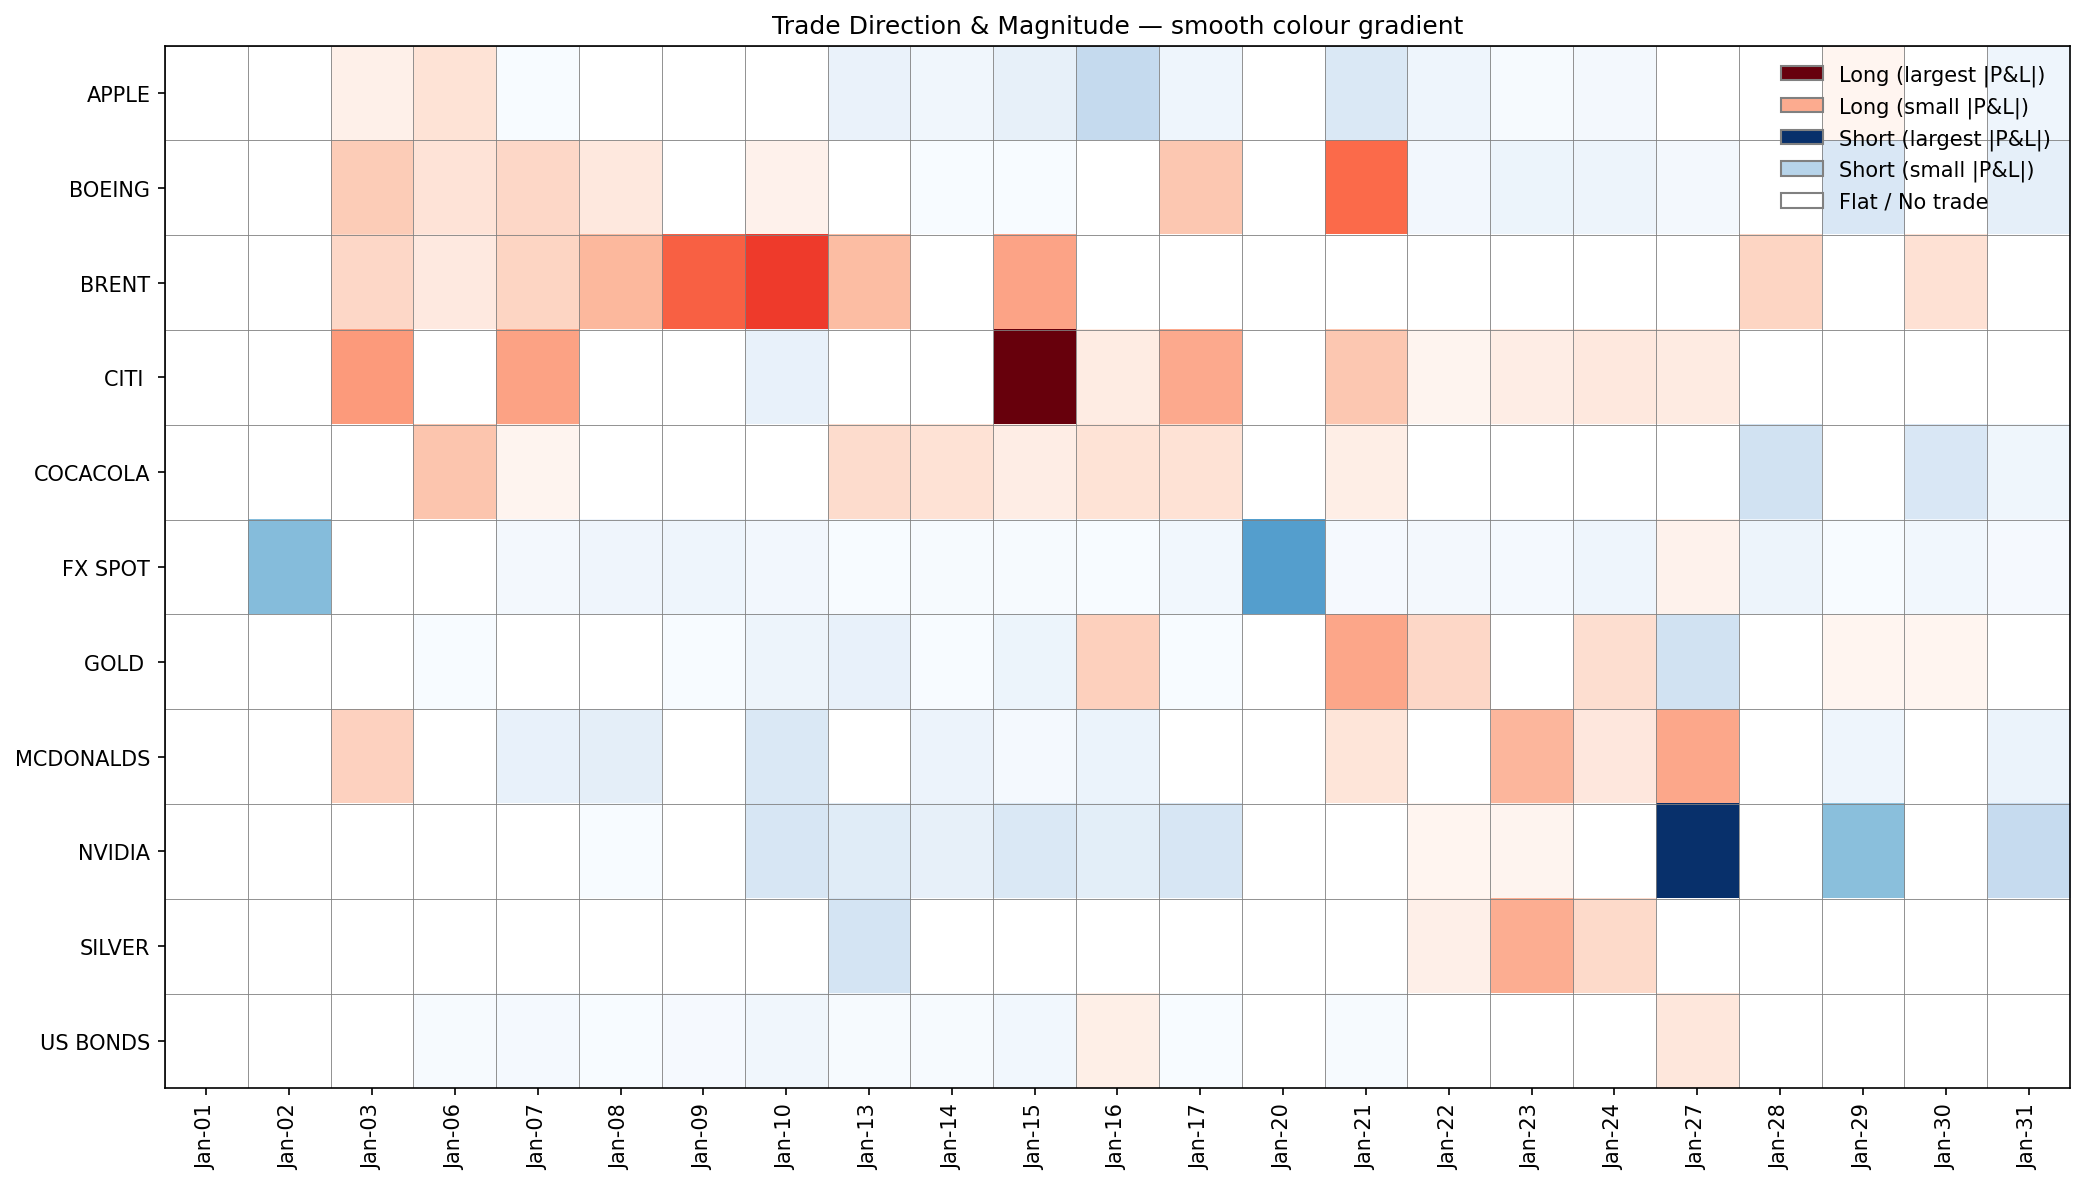

In [7]:
# ------------------------------------------------------ #
# 5f) HEAT‑MAP — smooth gradient of |P&L| on top of
#                 LONG (red) / SHORT (blue) direction
# ------------------------------------------------------ #
import numpy as np
from matplotlib import cm
from matplotlib.patches import Patch

# ── 1️⃣  day × asset tables for direction & P&L ────────────────────────────
# (a) summed $‑P&L per asset/day
pnl_df = (log_df.pivot_table(index="date",
                             columns="asset",
                             values="pnl",
                             aggfunc="sum")
                  .reindex(nav_df.index)          # keep full calendar
                  .fillna(0.0))

# (b) dominant trade direction ( +1 long, –1 short, 0 flat)
dir_map = {"LONG": 1, "SHORT": -1}
dir_df = (log_df.assign(dir_num=lambda d: d["dir"].map(dir_map).fillna(0))
                   .pivot_table(index="date",
                                columns="asset",
                                values="dir_num",
                                aggfunc="sum")
                   .reindex(nav_df.index)
                   .fillna(0)
                   .clip(-1, 1)                   # in case of mixed signals
                   .astype(int))

# ── 2️⃣  scale factors for smooth colour ramps ─────────────────────────────
abs_max_long  = pnl_df.where(dir_df== 1).abs().max().max() or 1e-12
abs_max_short = pnl_df.where(dir_df==-1).abs().max().max() or 1e-12

reds   = cm.get_cmap("Reds")    # 0→white‑ish, 1→deep red
blues  = cm.get_cmap("Blues")   # 0→white‑ish, 1→deep blue

def _colour(dir_val, pnl_val):
    """Return RGBA based on trade direction and |P&L| size."""
    if dir_val == 0:
        return (1, 1, 1, 1)                          # flat → white
    if dir_val > 0:                                  # LONG
        frac = abs(pnl_val) / abs_max_long
        return reds(frac)                            # smooth red ramp
    else:                                            # SHORT
        frac = abs(pnl_val) / abs_max_short
        return blues(frac)                           # smooth blue ramp

# ── 3️⃣  build RGBA image array (asset, date, rgba) ────────────────────────
n_dates, n_assets = len(pnl_df.index), len(pnl_df.columns)
rgba = np.empty((n_assets, n_dates, 4))

for d_i, (dir_row, pnl_row) in enumerate(zip(dir_df.itertuples(index=False),
                                             pnl_df.itertuples(index=False))):
    for a_i, (dir_val, pnl_val) in enumerate(zip(dir_row, pnl_row)):
        rgba[a_i, d_i, :] = _colour(dir_val, pnl_val)

# ── 4️⃣  plot ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
ax.imshow(rgba, aspect="auto")

# draw borders for each day/asset cell
ax.set_xticks(np.arange(-0.5, n_dates, 1),  minor=True)
ax.set_yticks(np.arange(-0.5, n_assets, 1), minor=True)
ax.grid(which="minor", color="grey", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# axis labels
ax.set_yticks(range(n_assets))
ax.set_yticklabels(pnl_df.columns)
ax.set_xticks(range(n_dates))
ax.set_xticklabels(pnl_df.index.strftime("%b‑%d"), rotation=90)

ax.set_title("Trade Direction & Magnitude — smooth colour gradient")

# legend (proxy patches)
legend_elems = [
    Patch(facecolor=reds(1.0),  edgecolor="grey", label="Long (largest |P&L|)"),
    Patch(facecolor=reds(0.3),  edgecolor="grey", label="Long (small |P&L|)"),
    Patch(facecolor=blues(1.0), edgecolor="grey", label="Short (largest |P&L|)"),
    Patch(facecolor=blues(0.3), edgecolor="grey", label="Short (small |P&L|)"),
    Patch(facecolor="white",    edgecolor="grey", label="Flat / No trade"),
]
ax.legend(handles=legend_elems, loc="upper right", frameon=False)

fig.tight_layout()
fig.savefig("fig_trade_dir_smooth_intensity.png")
print("Figure saved → fig_trade_dir_smooth_intensity.png")


/tmp/ipykernel_935224/742904076.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")    # 0→light‑pink, 1→deep red
/tmp/ipykernel_935224/742904076.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")   # 0→light‑sky, 1→deep blue


Figure saved → fig_trade_dir_profit_tint.png


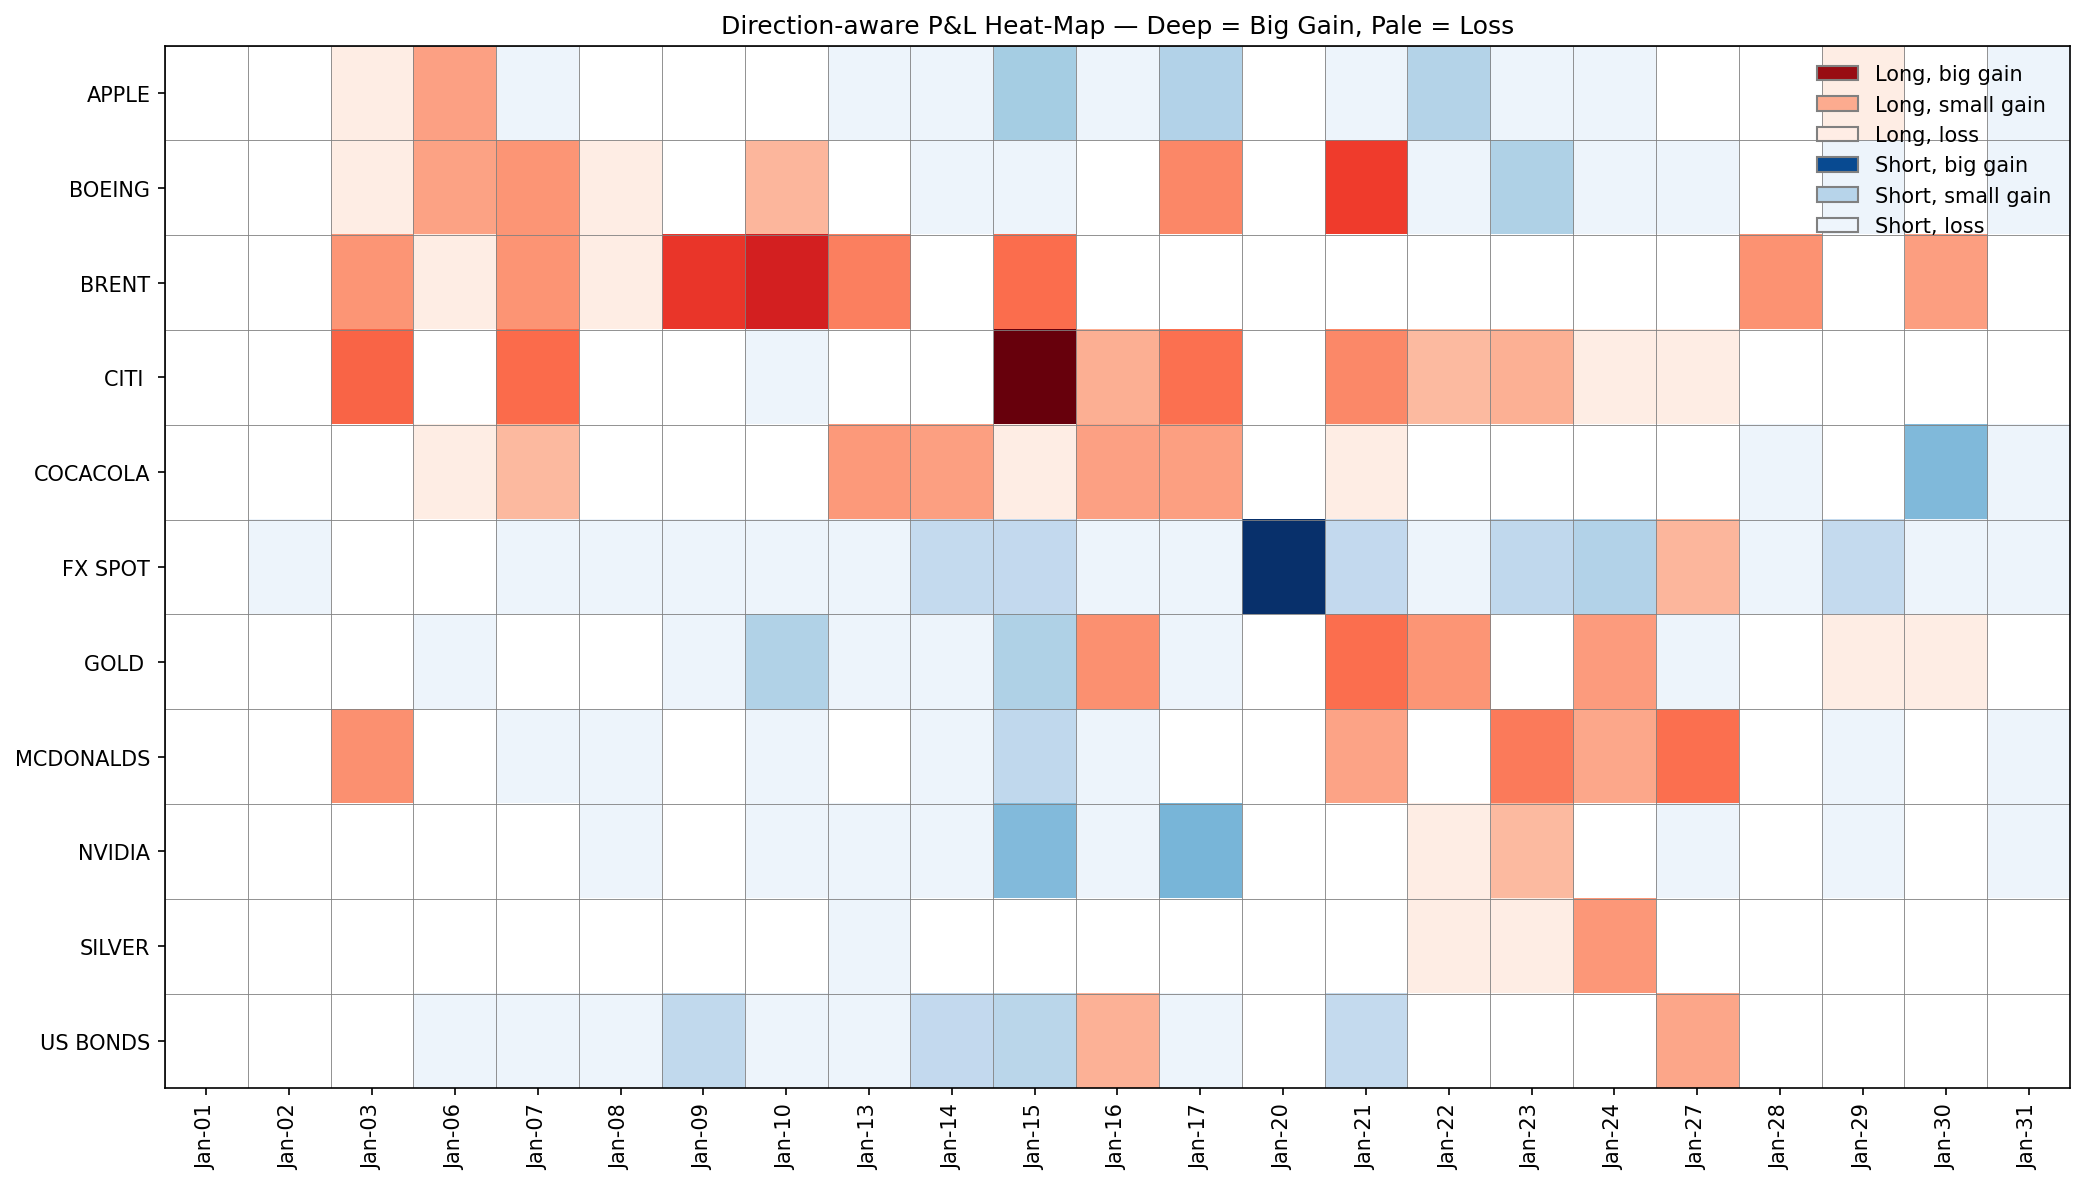

In [8]:
# ------------------------------------------------------ #
# 5f) HEAT‑MAP — Red = Long, Blue = Short
#                 Shade ∝ Profitability (deep = big gain)
#                 Pale tint = losing trade
# ------------------------------------------------------ #
import numpy as np
from matplotlib import cm
from matplotlib.patches import Patch

# 1️⃣  day‑×‑asset tables
pnl_df = (log_df.pivot_table(index="date",
                             columns="asset",
                             values="pnl",
                             aggfunc="sum")
                  .reindex(nav_df.index)
                  .fillna(0.0))

dir_map = {"LONG": 1, "SHORT": -1}
dir_df = (log_df.assign(dir_num=lambda d: d["dir"].map(dir_map).fillna(0))
                   .pivot_table(index="date",
                                columns="asset",
                                values="dir_num",
                                aggfunc="sum")
                   .reindex(nav_df.index)
                   .fillna(0)
                   .clip(-1, 1)
                   .astype(int))

# 2️⃣  separate max PRO‑fit values for long & short (used for scaling)
max_long_gain  = (pnl_df.where(dir_df ==  1)  # longs
                          .where(pnl_df > 0)  # only profitable ones
                          .max().max()) or 1e-12
max_short_gain = (-pnl_df.where(dir_df == -1)   # shorts
                           .where(pnl_df < 0)   # profitable (negative) pnl
                           .min().min()) or 1e-12  # min() gives biggest‑abs‑loss; negate

reds  = cm.get_cmap("Reds")    # 0→light‑pink, 1→deep red
blues = cm.get_cmap("Blues")   # 0→light‑sky, 1→deep blue

def _colour(direction, pnl):
    """RGBA where hue = direction, shade = profitability magnitude."""
    if direction == 0:
        return (1, 1, 1, 1)                      # flat = white
    # profit according to the *direction*
    effective_pnl = direction * pnl              # >0 = gain, <0 = loss
    if direction > 0:                            # LONG
        if effective_pnl <= 0:                   # losing long → pale tint
            return reds(0.05)
        frac = effective_pnl / max_long_gain
        return reds(0.25 + 0.75*frac)            # avoid too‑light colours on tiny gains
    else:                                        # SHORT
        if effective_pnl <= 0:                   # losing short → pale tint
            return blues(0.05)
        frac = effective_pnl / max_short_gain
        return blues(0.25 + 0.75*frac)

# 3️⃣  build RGBA image array (asset, date, rgba)
n_dates, n_assets = len(pnl_df.index), len(pnl_df.columns)
rgba = np.empty((n_assets, n_dates, 4))

for d_i, (dir_row, pnl_row) in enumerate(zip(dir_df.itertuples(index=False),
                                             pnl_df.itertuples(index=False))):
    for a_i, (dval, pval) in enumerate(zip(dir_row, pnl_row)):
        rgba[a_i, d_i, :] = _colour(dval, pval)

# 4️⃣  plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
ax.imshow(rgba, aspect="auto")

# cell borders
ax.set_xticks(np.arange(-0.5, n_dates, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n_assets, 1), minor=True)
ax.grid(which="minor", color="grey", linestyle="-", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# labels
ax.set_yticks(range(n_assets))
ax.set_yticklabels(pnl_df.columns)
ax.set_xticks(range(n_dates))
ax.set_xticklabels(pnl_df.index.strftime("%b‑%d"), rotation=90)
ax.set_title("Direction‑aware P&L Heat‑Map — Deep = Big Gain, Pale = Loss")

# legend proxies
legend_elems = [
    Patch(facecolor=reds(0.9), edgecolor="grey", label="Long, big gain"),
    Patch(facecolor=reds(0.3), edgecolor="grey", label="Long, small gain"),
    Patch(facecolor=reds(0.05),edgecolor="grey", label="Long, loss"),
    Patch(facecolor=blues(0.9),edgecolor="grey", label="Short, big gain"),
    Patch(facecolor=blues(0.3),edgecolor="grey", label="Short, small gain"),
    Patch(facecolor=blues(0.05),edgecolor="grey", label="Short, loss"),
]
ax.legend(handles=legend_elems, loc="upper right", frameon=False)

fig.tight_layout()
fig.savefig("fig_trade_dir_profit_tint.png")
print("Figure saved → fig_trade_dir_profit_tint.png")


/tmp/ipykernel_935224/2071427477.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")
/tmp/ipykernel_935224/2071427477.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


Figure saved → fig_trade_dir_profit_hatched.png


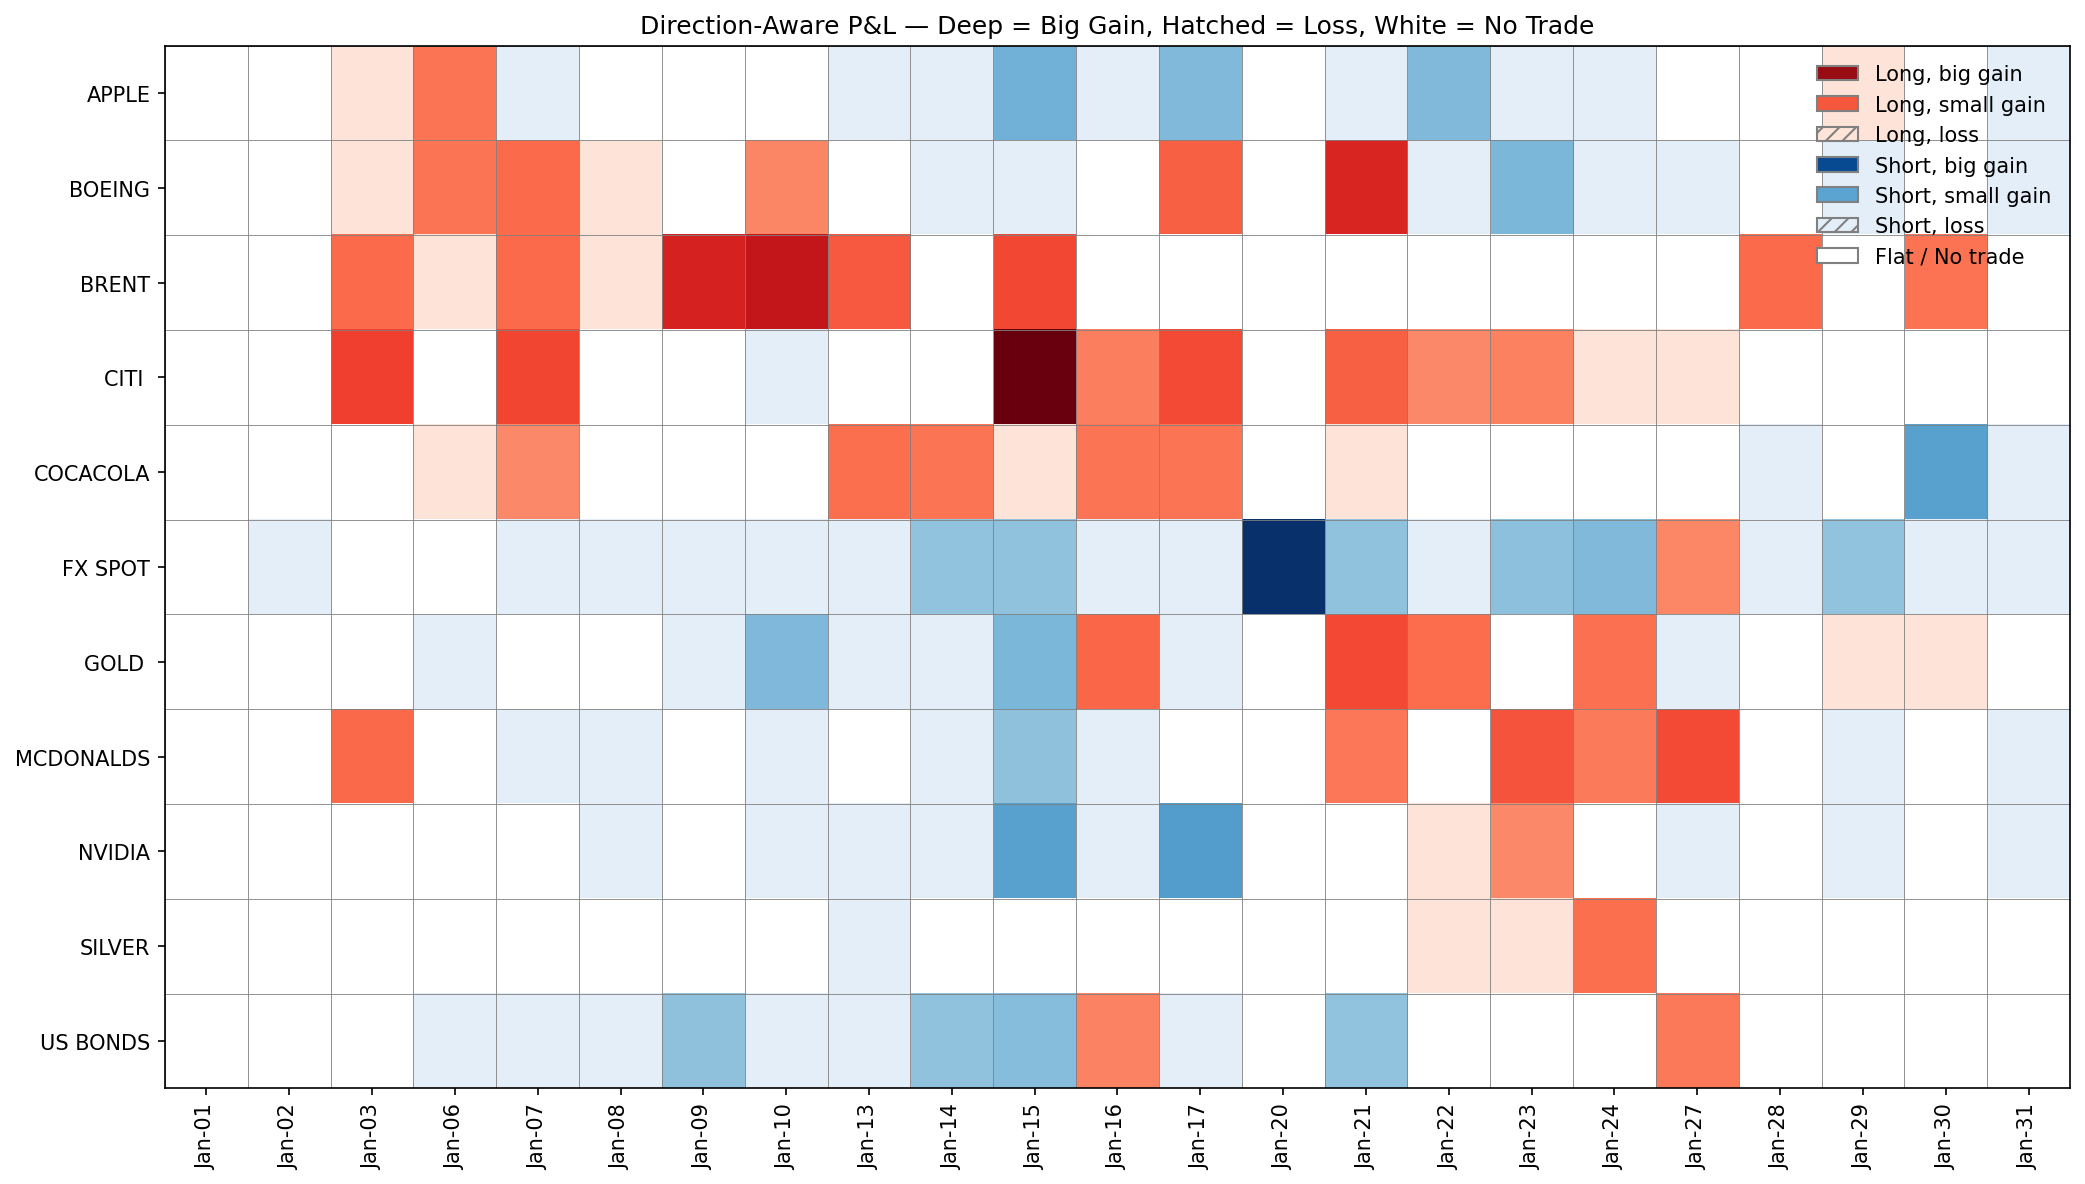

In [9]:
# ------------------------------------------------------ #
# 5f) Direction‑aware P&L Heat‑Map
#     • Hue   → direction   (Long = red, Short = blue)
#     • Shade → |P&L| gain  (deeper = bigger gain)
#     • Hatched legend for loss tiles
# ------------------------------------------------------ #
import numpy as np
from matplotlib import cm
from matplotlib.patches import Patch

# 1️⃣  Tables of P&L and trade direction
pnl_df = (log_df.pivot_table(index="date",
                             columns="asset",
                             values="pnl",
                             aggfunc="sum")
                  .reindex(nav_df.index)
                  .fillna(0.0))

dir_map = {"LONG": 1, "SHORT": -1}
dir_df = (log_df.assign(dir_num=lambda d: d["dir"].map(dir_map).fillna(0))
                   .pivot_table(index="date",
                                columns="asset",
                                values="dir_num",
                                aggfunc="sum")
                   .reindex(nav_df.index)
                   .fillna(0)
                   .clip(-1, 1)
                   .astype(int))

# 2️⃣  Scaling constants (largest profitable $$ by side)
max_long_gain  = (pnl_df.where((dir_df== 1) & (pnl_df>0)).max().max()) or 1e-12
max_short_gain = (-pnl_df.where((dir_df==-1) & (pnl_df<0)).min().min()) or 1e-12

reds  = cm.get_cmap("Reds")
blues = cm.get_cmap("Blues")

def _colour(direction, pnl):
    """RGBA based on direction & effectiveness."""
    if direction == 0:
        return (1,1,1,1)                                 # flat  → white
    eff = direction * pnl                                # profit in dir‑space
    # ─ LONG side ───────────────────────────────────────
    if direction > 0:
        if eff <= 0:  # loss
            return reds(0.10)                            # slightly darker empty red
        frac = eff / max_long_gain
        return reds(0.40 + 0.60*frac)                    # deeper start (0.40)
    # ─ SHORT side ──────────────────────────────────────
    if eff <= 0:      # loss on short
        return blues(0.10)
    frac = eff / max_short_gain
    return blues(0.40 + 0.60*frac)

# 3️⃣  Build RGBA volume (asset 1st, date 2nd)
n_dates, n_assets = len(pnl_df.index), len(pnl_df.columns)
rgba = np.empty((n_assets, n_dates, 4))

for d_i, (dir_row, pnl_row) in enumerate(zip(dir_df.itertuples(index=False),
                                             pnl_df.itertuples(index=False))):
    for a_i, (dval, pval) in enumerate(zip(dir_row, pnl_row)):
        rgba[a_i, d_i, :] = _colour(dval, pval)

# 4️⃣  Plot
fig, ax = plt.subplots(figsize=(14,8), dpi=150)
ax.imshow(rgba, aspect="auto")

# Grid
ax.set_xticks(np.arange(-0.5, n_dates, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n_assets, 1), minor=True)
ax.grid(which="minor", color="grey", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Labels
ax.set_yticks(range(n_assets));  ax.set_yticklabels(pnl_df.columns)
ax.set_xticks(range(n_dates));   ax.set_xticklabels(pnl_df.index.strftime("%b‑%d"), rotation=90)
ax.set_title("Direction‑Aware P&L — Deep = Big Gain, Hatched = Loss, White = No Trade")

# 5️⃣  Legend
legend_patches = [
    Patch(facecolor=reds(0.90),  edgecolor="grey",            label="Long, big gain"),
    Patch(facecolor=reds(0.55),  edgecolor="grey",            label="Long, small gain"),
    Patch(facecolor=reds(0.10),  edgecolor="grey", hatch="///", label="Long, loss"),
    Patch(facecolor=blues(0.90), edgecolor="grey",            label="Short, big gain"),
    Patch(facecolor=blues(0.55), edgecolor="grey",            label="Short, small gain"),
    Patch(facecolor=blues(0.10), edgecolor="grey", hatch="///", label="Short, loss"),
    Patch(facecolor="white",     edgecolor="grey",            label="Flat / No trade"),
]
ax.legend(handles=legend_patches, loc="upper right", frameon=False)

fig.tight_layout()
fig.savefig("fig_trade_dir_profit_hatched.png")
print("Figure saved → fig_trade_dir_profit_hatched.png")


/tmp/ipykernel_935224/4127808661.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")
/tmp/ipykernel_935224/4127808661.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


Figure saved → fig_trade_dir_profit_hatched.png


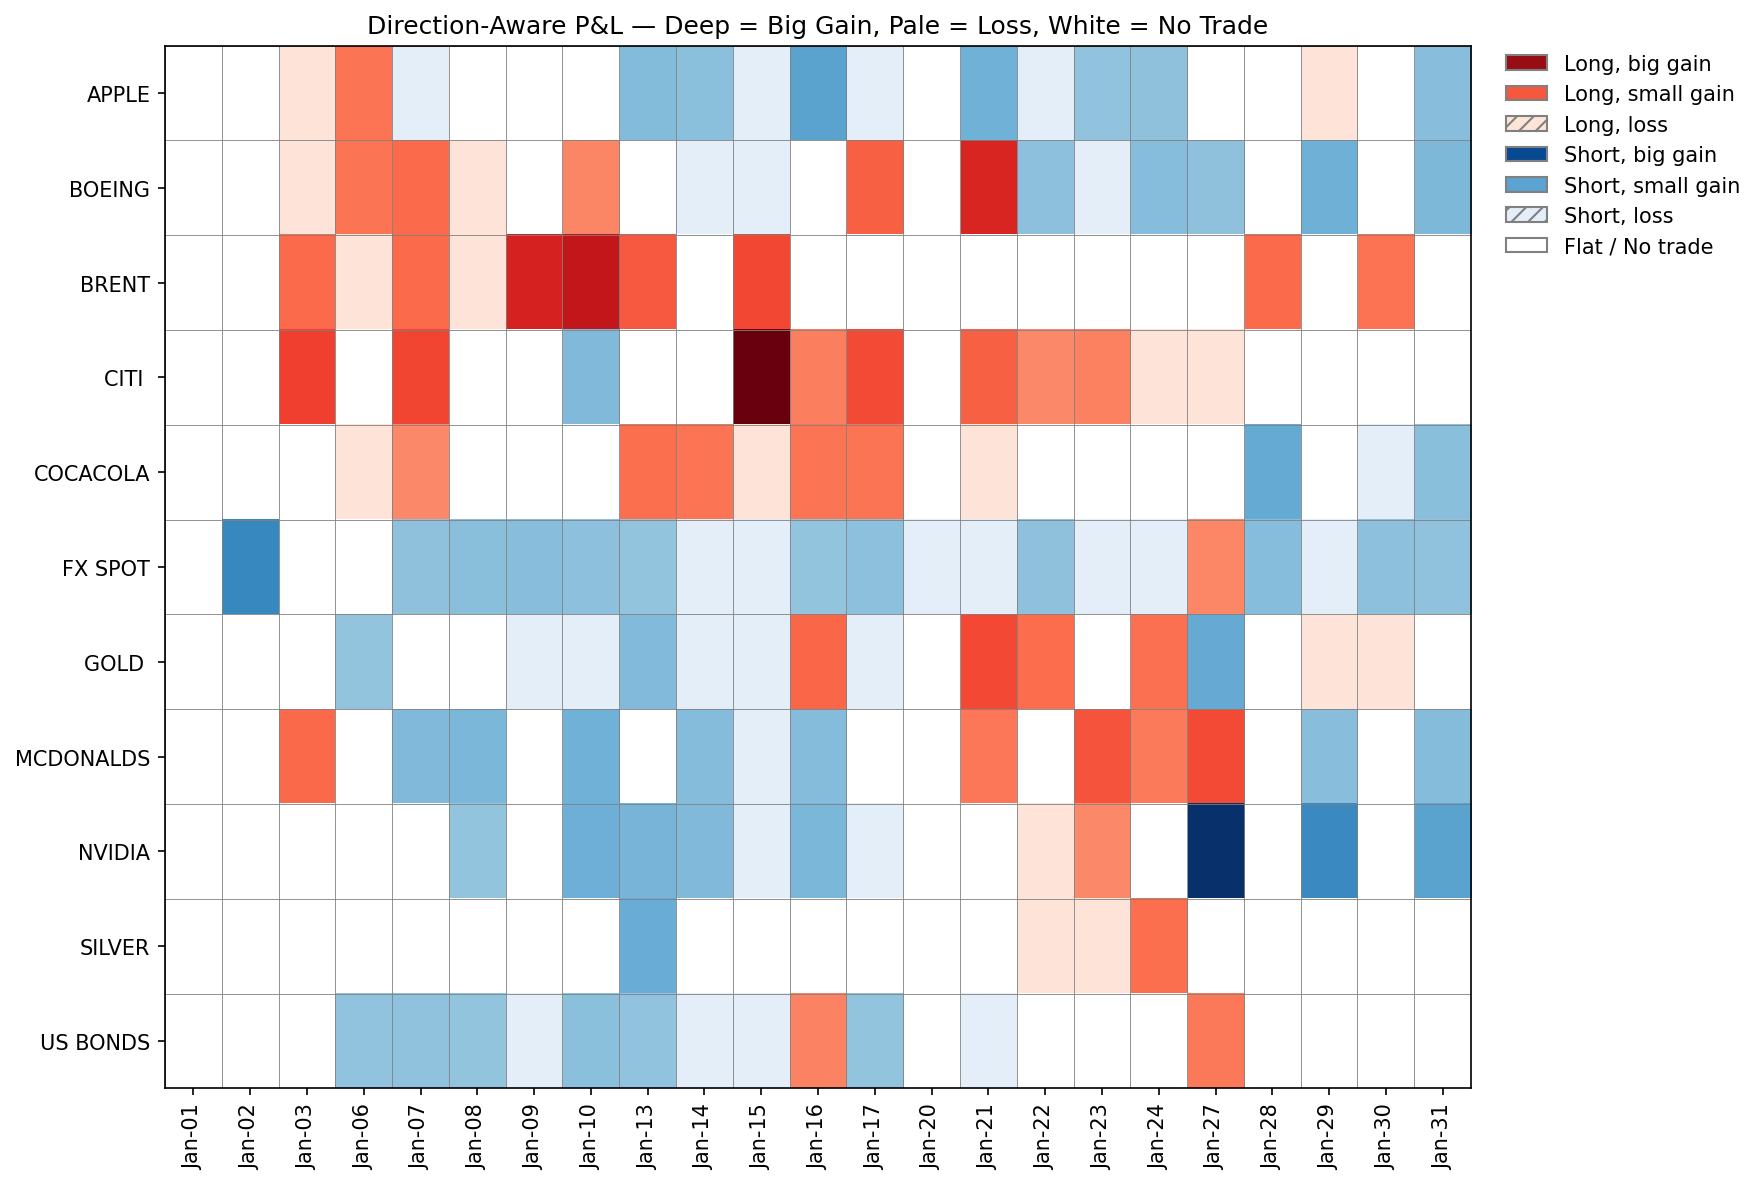

In [ ]:
# ------------------------------------------------------ #
# 5f) Direction‑Aware P&L Heat‑Map (legend outside)
# ------------------------------------------------------ #
import numpy as np
from matplotlib import cm
from matplotlib.patches import Patch

# ---------- 1)  data grids  ------------------------------------------------ #
pnl_df = (log_df.pivot_table(index="date",
                             columns="asset",
                             values="pnl",
                             aggfunc="sum")
                  .reindex(nav_df.index)
                  .fillna(0.0))

dir_map = {"LONG": 1, "SHORT": -1}
dir_df = (log_df.assign(dir_num=lambda d: d["dir"].map(dir_map).fillna(0))
                   .pivot_table(index="date",
                                columns="asset",
                                values="dir_num",
                                aggfunc="sum")
                   .reindex(nav_df.index)
                   .fillna(0)
                   .clip(-1, 1)
                   .astype(int))

# ---------- 2)  scaling for shade ----------------------------------------- #
max_gain_long  = pnl_df.where((dir_df== 1) & (pnl_df>0)).max().max() or 1e-12
max_gain_short = pnl_df.where((dir_df==-1) & (pnl_df>0)).max().max() or 1e-12
# (we scale only by PROFITS; losses always get the same very‑light tint)

reds  = cm.get_cmap("Reds")
blues = cm.get_cmap("Blues")

def _colour(direction, pnl):
    if direction == 0:                        # flat / no trade
        return (1,1,1,1)
    gain = pnl > 0
    if direction > 0:                        # LONG
        if not gain:                         # losing long
            return reds(0.10)
        return reds(0.40 + 0.60*(pnl/max_gain_long))
    else:                                    # SHORT
        if not gain:                         # losing short
            return blues(0.10)
        return blues(0.40 + 0.60*(pnl/max_gain_short))

# ---------- 3)  RGBA volume (asset, date, rgba) ---------------------------- #
n_dates, n_assets = len(pnl_df.index), len(pnl_df.columns)
rgba = np.empty((n_assets, n_dates, 4))

for d_i, (dir_row, pnl_row) in enumerate(zip(dir_df.itertuples(False),
                                             pnl_df.itertuples(False))):
    for a_i, (dval, pval) in enumerate(zip(dir_row, pnl_row)):
        rgba[a_i, d_i, :] = _colour(dval, pval)

# ---------- 4)  plot ------------------------------------------------------- #
fig, ax = plt.subplots(figsize=(14,8), dpi=150)
ax.imshow(rgba, aspect="auto")

# grid
ax.set_xticks(np.arange(-0.5, n_dates, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n_assets, 1), minor=True)
ax.grid(which="minor", color="grey", linewidth=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# labels
ax.set_yticks(range(n_assets)); ax.set_yticklabels(pnl_df.columns)
ax.set_xticks(range(n_dates));  ax.set_xticklabels(pnl_df.index.strftime("%b‑%d"), rotation=90)
ax.set_title("Direction‑Aware P&L — Deep = Big Gain, Pale = Loss, White = No Trade")

# legend (placed outside the axes)
legend_patches = [
    Patch(facecolor=reds(0.90), edgecolor="grey",             label="Long, big gain"),
    Patch(facecolor=reds(0.55), edgecolor="grey",             label="Long, small gain"),
    Patch(facecolor=reds(0.10), edgecolor="grey", hatch="///",label="Long, loss"),
    Patch(facecolor=blues(0.90),edgecolor="grey",             label="Short, big gain"),
    Patch(facecolor=blues(0.55),edgecolor="grey",             label="Short, small gain"),
    Patch(facecolor=blues(0.10),edgecolor="grey", hatch="///",label="Short, loss"),
    Patch(facecolor="white",    edgecolor="grey",             label="Flat / No trade"),
]
ax.legend(handles=legend_patches,
          loc="upper left",
          bbox_to_anchor=(1.02, 1),   # just outside the right edge
          borderaxespad=0.0,
          frameon=False)

fig.tight_layout(rect=[0,0,0.85,1])   # leave room on the right for legend
fig.savefig("fig_trade_dir_profit_hatched.png")
print("Figure saved → fig_trade_dir_profit_hatched.png")
